## Capstone Project - ListingAssistant - Short term rental



### Business model to assist existing and new property owner to predict on the daily listing price for their short term rentals

Problem Statement: Short term rental owners don't have convenient way to decide on property listing price, thereby losing potential rental. Platforms like VRBO and AirBnB provide dynamic price adjustments, which property owner do not control.

### The Data

The dataset below is from [opendatasoft]() and contains short term rentals listings for the city of San Franscisco.


## Approach
1. Create regression models - Linear,DecisionTree,RandomForest,GradientBoost
2. Evaluate the models 
3. Save the model
4. Deploy the model
5. Setup api interface to the model

In [2667]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
import pickle
from numpy import random
from sklearn import datasets, ensemble
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,PolynomialFeatures,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint
from scipy import stats

## Load dataset
#### Load state and zipcode features as string datatype

In [2668]:
# Load San Francisco airbnb property listings
listings= pd.read_csv("SF_airbnb-listings.csv",dtype={"State": "string","Zipcode":"string"})

# Complete dataset
#listings= pd.read_csv("airbnb-listings-all.csv",dtype={"State": "string","Zipcode":"string"})

In [2669]:
# Dataset dimensions 
listings.shape

(8680, 89)

## Exploratory Data Analysis

In [2670]:
# Display listings columns
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8680 entries, 0 to 8679
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              8680 non-null   int64  
 1   Listing Url                     8680 non-null   object 
 2   Scrape ID                       8680 non-null   int64  
 3   Last Scraped                    8680 non-null   object 
 4   Name                            8680 non-null   object 
 5   Summary                         8409 non-null   object 
 6   Space                           6205 non-null   object 
 7   Description                     8678 non-null   object 
 8   Experiences Offered             8680 non-null   object 
 9   Neighborhood Overview           5170 non-null   object 
 10  Notes                           4125 non-null   object 
 11  Transit                         5436 non-null   object 
 12  Access                          53

In [2671]:
### Observations - HostAcceptanceRate, HasAvailability features do not contain data. 
# Fewer properties have shared their sqrt.

# Load the top 5 samples
listings.head(5)

ID                            Listing Url       Scrape ID  \
0   9316519   https://www.airbnb.com/rooms/9316519  20170401232214   
1  11461771  https://www.airbnb.com/rooms/11461771  20170401232214   
2    910338    https://www.airbnb.com/rooms/910338  20170401232214   
3   4902729   https://www.airbnb.com/rooms/4902729  20170401232214   
4  15342398  https://www.airbnb.com/rooms/15342398  20170401232214   

  Last Scraped                                               Name  \
0   2017-04-02                Central Dwntwn USq Studio Timeshare   
1   2017-04-02  Startup Basecamp,org The First Startup Hotel (#3)   
2   2017-04-02                 Cute, sunny studio right downtown!   
3   2017-04-02                 Private Room Near Downtown SF (15)   
4   2017-04-02  1bdrm Wyndham Canterbury*SPECIAL BOOK NOW PRIC...   

                                             Summary  \
0  The Donatello is a timeshare/hotel which is on...   
1  We are much more than just an affordable, qual...   
2  Fully furnished studio with all amenities you ...   
3  Come stay in a dorm like style apartment. A pr...   
4  Once you settle in, you’ll find that San Franc...   

                                               Space  \
0  DESCRIPTION With 400 square feet of space and ...   
1  This listing price is for Double Occupancy Roo...   
2  Apartment is a quiet, fully furnished studio i...   
3  The apartment located at the heart of San Fran...   
4  Spacious living rooms with large-screen TV, DV...   

                                         Description Experiences Offered  \
0  The Donatello is a timeshare/hotel which is on...                none   
1  We are much more than just an affordable, qual...                none   
2  Fully furnished studio with all amenities you ...                none   
3  Come stay in a dorm like style apartment. A pr...                none   
4  Once you settle in, you’ll find that San Franc...                none   

                               Neighborhood Overview  \
0  Lunch at the Rotunda Restaurant in Nieman Marc...   
1  Startup Basecamp is conveniently located in th...   
2  There are tons of places to eat and have a dri...   
3  Although the City is big the neighborhood has ...   
4  At the heart of downtown in one of the most dy...   

                                               Notes  \
0  NOTE: Parking is mandatory valet and is 32 per...   
1                                                NaN   
2                                                NaN   
3  This space is located in the Tenderloin distri...   
4  Please note there will be a 250 hold for incid...   

                                             Transit  \
0   About five blocks from BART (Powell St Station).   
1                                                NaN   
2  The apt is close to most public transportation...   
3  Bart (subway) is a 8 minute walk.  Bus and Mun...   
4                                                NaN   

                                              Access  \
0   Guests will have full access to onsite amenities   
1  We have a 24 hour check-in desk, so it’s possi...   
2                                                NaN   
3                                 Bathroom & Kitchen   
4  Front Desk Services:     Concierge Service    ...   

                                         Interaction  \
0  I am not onsite, and the front desk can attend...   
1  We know that jumping into the Silicon Valley e...   
2                                                NaN   
3           As much or as little as they would like.   
4  I will be available 24/7 by phone call or text...   

                                         House Rules  \
0  CHANGES/CANCELLATIONS - Understand that once a...   
1  Camper's community rules:  1) Work hard and sh...   
2  I live in this apt when I am in San Francisco,...   
3                  No Smoking on Premises.  No pets.   
4  - Must have ID and Major Credit Card for check...   

                    

In [2672]:
# Info on various columns
listings.describe()

ID     Scrape ID       Host ID  Host Response Rate  \
count  8.680000e+03  8.680000e+03  8.680000e+03         5957.000000   
mean   8.912386e+06  2.017040e+13  2.325039e+07           94.346651   
std    5.411146e+06  8.203598e-02  2.817486e+07           16.085918   
min    9.580000e+02  2.017040e+13  4.600000e+01            0.000000   
25%    4.125074e+06  2.017040e+13  3.243848e+06           99.000000   
50%    9.152642e+06  2.017040e+13  1.079851e+07          100.000000   
75%    1.367685e+07  2.017040e+13  3.407492e+07          100.000000   
max    1.800883e+07  2.017040e+13  1.233930e+08          100.000000   

       Host Acceptance Rate  Host Listings Count  Host Total Listings Count  \
count                   0.0          8672.000000                8672.000000   
mean                    NaN             6.091790                   6.091790   
std                     NaN            36.652761                  36.652761   
min                     NaN             0.000000                   0.000000   
25%                     NaN             1.000000                   1.000000   
50%                     NaN             1.000000                   1.000000   
75%                     NaN             2.000000                   2.000000   
max                     NaN          1114.000000                1114.000000   

       Neighbourhood Group Cleansed     Latitude    Longitude  Accommodates  \
count                           0.0  8680.000000  8680.000000   8680.000000   
mean                            NaN    37.767812  -122.430244      3.163940   
std                             NaN     0.021854     0.025478      1.998493   
min                             NaN    37.708293  -122.511500      1.000000   
25%                             NaN    37.753386  -122.442000      2.000000   
50%                             NaN    37.769862  -122.425406      2.000000   
75%                             NaN    37.785543  -122.412447      4.000000   
max                             NaN    37.831093  -122.364759     16.000000   

         Bathrooms     Bedrooms         Beds  Square Feet        Price  \
count  8644.000000  8672.000000  8663.000000   184.000000  8484.000000   
mean      1.266948     1.334871     1.706684   964.375000   204.700141   
std       0.617325     0.891375     1.170211   700.835049   154.448638   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     1.000000   450.000000   100.000000   
50%       1.000000     1.000000     1.000000   900.000000   155.000000   
75%       1.500000     2.000000     2.000000  1300.000000   250.000000   
max       8.000000    10.000000    16.000000  3000.000000   999.000000   

       Weekly Price  Monthly Price  Security Deposit  Cleaning Fee  \
count   1003.000000    1607.000000       3503.000000   6269.000000   
mean     690.407777    4308.152458        319.894091     79.348381   
std      184.552440    3823.649854        178.167004     56.668802   
min      200.000000     350.000000         95.000000      5.000000   
25%      550.000000    2500.000000        200.000000     40.000000   
50%      700.000000    3500.000000        300.000000     70.000000   
75%      850.000000    5000.000000        500.000000    100.000000   
max      999.000000   60000.000000        999.000000    850.000000   

       Guests Included  Extra People  Minimum Nights  Maximum Nights  \
count      8680.000000   8680.000000     8680.000000    8.680000e+03   
mean          1.584447     13.996889        4.444240    2.481284e+05   
std           1.212149     26.765127       16.550575    2.304995e+07   
min           1.000000      0.000000        1.000000    1.000000e+00   
25%           1.000000      0.000000        1.000000    2.675000e+01   
50%           1.000000      0.000000        2.000000    1.125000e+03   
75%           2.000000     25.000000        3.000000    1.125000e+03   
max          12.000000    300.000000     1000.000000    2.147484e+09   

      

In [2673]:
# Compute the missing count and percentage of every column
def column_with_null_value(df):
    df_col_null = pd.DataFrame(columns=['Column','Null#','Null# Percentage'])
    for col in df.columns: 
        if df[col].isnull().sum() != 0:
            df_col_null.loc[len(df_col_null)] = [col, df[col].isnull().sum(),round(df[col].isnull().mean() * 100, 2)]
    return df_col_null

In [2674]:
# Calculate columns with missing value
column_with_null_value(listings)

Column  Null#  Null# Percentage
0                        Summary    271              3.12
1                          Space   2475             28.51
2                    Description      2              0.02
3          Neighborhood Overview   3510             40.44
4                          Notes   4555             52.48
5                        Transit   3244             37.37
6                         Access   3347             38.56
7                    Interaction   3567             41.09
8                    House Rules   2838             32.70
9                  Thumbnail Url   1471             16.95
10                    Medium Url   1471             16.95
11                   Picture Url      7              0.08
12                XL Picture Url   1471             16.95
13                     Host Name      8              0.09
14                    Host Since      8              0.09
15                 Host Location     30              0.35
16                    Host About   2775             31.97
17            Host Response Time   2723             31.37
18            Host Response Rate   2723             31.37
19          Host Acceptance Rate   8680            100.00
20            Host Thumbnail Url      8              0.09
21              Host Picture Url      8              0.09
22            Host Neighbourhood    737              8.49
23           Host Listings Count      8              0.09
24     Host Total Listings Count      8              0.09
25            Host Verifications      5              0.06
26                 Neighbourhood    916             10.55
27  Neighbourhood Group Cleansed   8680            100.00
28                       Zipcode    109              1.26
29                        Market     32              0.37
30                     Bathrooms     36              0.41
31                      Bedrooms      8              0.09
32                          Beds     17              0.20
33                     Amenities     73              0.84
34                   Square Feet   8496             97.88
35                         Price    196              2.26
36                  Weekly Price   7677             88.44
37                 Monthly Price   7073             81.49
38              Security Deposit   5177             59.64
39                  Cleaning Fee   2411             27.78
40              Has Availability   8680            100.00
41                  First Review   1958             22.56
42                   Last Review   1952             22.49
43          Review Scores Rating   2046             23.57
44        Review Scores Accuracy   2061             23.74
45     Review Scores Cleanliness   2058             23.71
46         Review Scores Checkin   2069             23.84
47   Review Scores Communication   2057             23.70
48        Review Scores Location   2068             23.82
49           Review Scores Value   2071             23.86
50                       License   7621             87.80
51            Jurisdiction Names      1              0.01
52             Reviews per Month   1958             22.56
53                      Features      2              0.02

In [2675]:
# Check whether there are any duplicate samples
listings.duplicated().sum()

if listings.duplicated().sum() != 0:
    listings.drop_duplicates()
else:
    print('no duplicate samples found')

no duplicate samples found


## Preprocessing

In [2676]:
# Normalize the column names - Replace space with underscore and convert to lowercase
listings.columns = [col.lower().replace(" ","_") for col in listings.columns]

In [2677]:
# Count on non unique hosts
listings["host_id"].nunique()

6899

In [2678]:
# Inspect every column for its count,unique and null values
inspect_data = pd.DataFrame(index = list(listings))
inspect_data['type']    = listings.dtypes
inspect_data['count']   = listings.count()
inspect_data['nunique'] = listings.nunique()
inspect_data['%unique'] = inspect_data['nunique'] / len(listings) * 100
inspect_data['null']    = listings.isnull().sum()
inspect_data            = pd.concat([inspect_data, listings.describe().T.drop('count', axis = 1)], axis = 1)
inspect_data

type  count  nunique     %unique  null  \
id                                int64   8680     8680  100.000000     0   
listing_url                      object   8680     8680  100.000000     0   
scrape_id                         int64   8680        1    0.011521     0   
last_scraped                     object   8680        1    0.011521     0   
name                             object   8680     8552   98.525346     0   
summary                          object   8409     7973   91.854839   271   
space                            object   6205     5882   67.764977  2475   
description                      object   8678     8402   96.797235     2   
experiences_offered              object   8680        1    0.011521     0   
neighborhood_overview            object   5170     4665   53.744240  3510   
notes                            object   4125     3565   41.071429  4555   
transit                          object   5436     4913   56.601382  3244   
access                           object   5333     4898   56.428571  3347   
interaction                      object   5113     4667   53.767281  3567   
house_rules                      object   5842     5338   61.497696  2838   
thumbnail_url                    object   7209     7203   82.983871  1471   
medium_url                       object   7209     7203   82.983871  1471   
picture_url                      object   8673     8664   99.815668     7   
xl_picture_url                   object   7209     7203   82.983871  1471   
host_id                           int64   8680     6899   79.481567     0   
host_url                         object   8680     6899   79.481567     0   
host_name                        object   8672     2933   33.790323     8   
host_since                       object   8672     2325   26.785714     8   
host_location                    object   8650      312    3.594470    30   
host_about                       object   5905     4485   51.670507  2775   
host_response_time               object   5957        4    0.046083  2723   
host_response_rate              float64   5957       56    0.645161  2723   
host_acceptance_rate            float64      0        0    0.000000  8680   
host_thumbnail_url               object   8672     6878   79.239631     8   
host_picture_url                 object   8672     6878   79.239631     8   
host_neighbourhood               object   7943      155    1.785714   737   
host_listings_count             float64   8672       60    0.691244     8   
host_total_listings_count       float64   8672       60    0.691244     8   
host_verifications               object   8675      268    3.087558     5   
street                           object   8680      202    2.327189     0   
neighbourhood                    object   7764       60    0.691244   916   
neighbourhood_cleansed           object   8680       37    0.426267     0   
neighbourhood_group_cleansed    float64      0        0    0.000000  8680   
city                             object   8680        1    0.011521     0   
state                            string   8680        1    0.011521     0   
zipcode                          string   8571       30    0.345622   109   
market                           object   8648        5    0.057604    32   
smart_location                   object   8680        3    0.034562     0   
country_code                     object   8680        2    0.023041     0   
country                          object   8680        2    0.023041     0   
latitude                        float64   8680     8680  100.000000     0   
longitude                       float64   8680     8680  100.000000     0   
property_type                    object   8680       24    0.276498     0   
room_type                        object   8680        3    0.034562     0   
accommodates                      int64   8680       15    0.172811     0   
bathrooms                       float64   8644       14    0.161290    36   
bedrooms                       

In [2679]:
# Display null count of every column
listings.isnull().sum()

id                                   0
listing_url                          0
scrape_id                            0
last_scraped                         0
name                                 0
summary                            271
space                             2475
description                          2
experiences_offered                  0
neighborhood_overview             3510
notes                             4555
transit                           3244
access                            3347
interaction                       3567
house_rules                       2838
thumbnail_url                     1471
medium_url                        1471
picture_url                          7
xl_picture_url                    1471
host_id                              0
host_url                             0
host_name                            8
host_since                           8
host_location                       30
host_about                        2775
host_response_time       

In [2680]:
# Verify whether the proerty location address columns
listings[['street','city','state','zipcode','country']].isnull().sum()

street       0
city         0
state        0
zipcode    109
country      0
dtype: int64

In [2681]:
# Locate all samples containing any address field as null
address_column_null = listings.loc[ listings['street'].isnull() |
                                    listings['city'].isnull()   |
                                    listings['state'].isnull()  |
                                    listings['zipcode'].isnull()|
                                    listings['country'].isnull() ]
# Print sample if any address field is null
print(address_column_null[['street','city','state','zipcode','country']])

                                                 street           city state  \
64                     San Francisco, CA, United States  San Francisco    CA   
167                    San Francisco, CA, United States  San Francisco    CA   
239                    San Francisco, CA, United States  San Francisco    CA   
261   Mission District, San Francisco, CA, United St...  San Francisco    CA   
287                    San Francisco, CA, United States  San Francisco    CA   
460                    San Francisco, CA, United States  San Francisco    CA   
632                    San Francisco, CA, United States  San Francisco    CA   
689                    San Francisco, CA, United States  San Francisco    CA   
754                    San Francisco, CA, United States  San Francisco    CA   
840                    San Francisco, CA, United States  San Francisco    CA   
948                    San Francisco, CA, United States  San Francisco    CA   
959                    San Francisco, CA

In [2682]:
# Inspect street column
listings['street'].unique()

array(['Downtown, San Francisco, CA 94102, United States',
       'Western Addition/NOPA, San Francisco, CA 94109, United States',
       'Downtown, San Francisco, CA 94109, United States',
       'Tenderloin, San Francisco, CA 94109, United States',
       'Union Square, San Francisco, CA 94102, United States',
       'Nob Hill, San Francisco, CA 94108, United States',
       'Western Addition/NOPA, San Francisco, CA 94102, United States',
       'Lakeshore, San Francisco, CA 94132, United States',
       'Russian Hill, San Francisco, CA 94109, United States',
       "Fisherman's Wharf, San Francisco, CA 94109, United States",
       'North Beach, San Francisco, CA 94133, United States',
       'Excelsior, San Francisco, CA 94112, United States',
       'San Francisco, CA 94134, United States',
       'Parkside, San Francisco, CA 94116, United States',
       'Outer Sunset, San Francisco, CA 94116, United States',
       'San Francisco, CA 94105, United States',
       'Financial Dist

In [2683]:
#street name contains the complete address. Extract just the street name
listings['street']=listings['street'].str.split(', ', expand=True)[0]

In [2684]:
####listings['street'].value_counts()

In [2685]:
#print(np.where(listings['street']=='10 min walk to Dogpatch' )[0][0])
#listings.drop([np.where(listings['street']=='10 min walk to Dogpatch')[0][0]], axis=0, inplace=True)

In [2686]:
# Display unique zipcodes
listings['zipcode'].unique()

<StringArray>
[       '94102',        '94109',        '94108',        '94132',
        '94133',        '94112',        '94134',        '94116',
        '94105',        '94111',        '94107',        '94110',
        '94117',        '94115',        '94121',        '94114',
        '94131',           <NA>,        '94122',        '94130',
        '94103',        '94118',        '94123',        '94124',
        '94158',        '94127',        '94104',   '94107-1273',
        '94129',        '94401', '94158\n94158']
Length: 31, dtype: string

In [2687]:
# cleanup zipcode
listings['zipcode']=listings['zipcode'].str.split('-', expand=True)[0]
listings['zipcode']=listings['zipcode'].str.split('\n', expand=True)[0]

In [2688]:
# Display spread of property zipcodes
listings['zipcode'].value_counts()

94110    1286
94117     743
94109     738
94114     701
94103     512
94107     469
94115     434
94102     424
94131     355
94123     329
94112     329
94122     328
94118     300
94133     296
94121     241
94108     230
94116     185
94127     129
94105     123
94124     111
94134      97
94132      88
94158      50
94111      27
94130      23
94104      20
94129       2
94401       1
Name: zipcode, dtype: Int64

In [2689]:
# Display neighbourhood names
listings['neighbourhood_cleansed'].unique()

array(['Downtown/Civic Center', 'Lakeshore', 'Russian Hill', 'Excelsior',
       'Parkside', 'Financial District', 'Ocean View', 'Mission',
       'Western Addition', 'Seacliff', 'Haight Ashbury', 'Outer Mission',
       'Noe Valley', 'Inner Sunset', 'Treasure Island/YBI',
       'Outer Richmond', 'Crocker Amazon', 'Bernal Heights', 'Chinatown',
       'North Beach', 'Nob Hill', 'Inner Richmond', 'Marina', 'Bayview',
       'Pacific Heights', 'Presidio Heights', 'South of Market',
       'Glen Park', 'Potrero Hill', 'Castro/Upper Market', 'Twin Peaks',
       'West of Twin Peaks', 'Outer Sunset', 'Visitacion Valley',
       'Presidio', 'Golden Gate Park', 'Diamond Heights'], dtype=object)

In [2690]:
# Display property count for various neighbourhoods
listings['neighbourhood_cleansed'].value_counts()

Mission                  1034
Western Addition          778
South of Market           616
Downtown/Civic Center     563
Castro/Upper Market       480
Bernal Heights            449
Haight Ashbury            413
Noe Valley                388
Nob Hill                  322
Marina                    306
Potrero Hill              286
Inner Richmond            286
Outer Sunset              254
Pacific Heights           243
Russian Hill              223
Outer Richmond            195
North Beach               180
Inner Sunset              170
Outer Mission             163
Excelsior                 153
Chinatown                 151
Financial District        140
West of Twin Peaks        123
Parkside                  121
Bayview                   118
Ocean View                104
Twin Peaks                101
Glen Park                  82
Lakeshore                  52
Presidio Heights           39
Visitacion Valley          38
Crocker Amazon             25
Treasure Island/YBI        25
Seacliff  

In [2691]:
# Check whether property list doesn't contain price. If price is not listed, need to remove the listing
listings['price'].isna().sum()

196

In [2692]:
# RoomType and Bed# of null listing price
print(listings.loc[listings['price'].isnull()][['price','room_type','beds']])

      price        room_type  beds
68      NaN  Entire home/apt   1.0
136     NaN  Entire home/apt   6.0
195     NaN  Entire home/apt   1.0
361     NaN  Entire home/apt   2.0
412     NaN  Entire home/apt   4.0
443     NaN  Entire home/apt   2.0
503     NaN  Entire home/apt   3.0
523     NaN  Entire home/apt   6.0
756     NaN  Entire home/apt   3.0
777     NaN  Entire home/apt   9.0
793     NaN     Private room   1.0
859     NaN  Entire home/apt   2.0
901     NaN  Entire home/apt   5.0
927     NaN  Entire home/apt   1.0
937     NaN  Entire home/apt   2.0
941     NaN  Entire home/apt   3.0
1014    NaN  Entire home/apt   1.0
1049    NaN  Entire home/apt   4.0
1106    NaN  Entire home/apt   3.0
1254    NaN  Entire home/apt   3.0
1338    NaN  Entire home/apt   4.0
1408    NaN  Entire home/apt   9.0
1419    NaN  Entire home/apt   4.0
1549    NaN     Private room   1.0
1612    NaN  Entire home/apt   4.0
1631    NaN  Entire home/apt   3.0
1632    NaN  Entire home/apt   2.0
1732    NaN  Entire 

In [2693]:
# Display the median listings price
print(listings['price'].median())

155.0


In [2694]:
# Remove listings where listing price = null
listings.dropna(subset=['price'],inplace=True)

In [2695]:
# Check on how many property listing requires securoty deposit
listings['security_deposit'].isna().sum()

5002

In [2696]:
# Display unique security deposit amount
listings['security_deposit'].unique()

array([ nan, 180., 100.,  95., 500., 250., 150., 200., 400., 300., 350.,
       550., 750., 175., 600., 125., 120., 257., 450., 700., 800., 199.,
       575., 950., 599., 299., 850., 333., 900., 201., 275., 975., 107.,
       650., 475., 185., 190., 165.,  99., 775., 399., 217., 999., 295.,
       220., 325., 298., 380., 390., 315., 555., 225., 499., 666., 335.,
       312., 474., 949., 483., 111., 425., 240., 115., 349., 189., 397.,
       249., 375., 290., 130., 699., 210., 105., 495., 297., 145., 149.,
       680.])

In [2697]:
# Display securityDeposit amount count 
listings['security_deposit'].value_counts()

500.0    900
200.0    520
100.0    487
300.0    404
250.0    320
150.0    214
400.0    144
350.0     81
95.0      59
600.0     58
750.0     47
800.0     31
450.0     21
700.0     18
175.0     17
120.0     14
125.0     12
180.0      9
550.0      8
900.0      8
199.0      7
950.0      7
99.0       6
499.0      5
275.0      5
225.0      4
399.0      4
850.0      4
975.0      4
190.0      3
165.0      3
775.0      3
299.0      3
650.0      2
475.0      2
666.0      2
349.0      2
575.0      2
999.0      2
220.0      2
290.0      2
249.0      1
240.0      1
115.0      1
189.0      1
397.0      1
130.0      1
375.0      1
111.0      1
699.0      1
210.0      1
105.0      1
495.0      1
297.0      1
145.0      1
149.0      1
425.0      1
312.0      1
483.0      1
325.0      1
185.0      1
107.0      1
201.0      1
333.0      1
599.0      1
217.0      1
295.0      1
298.0      1
949.0      1
380.0      1
390.0      1
315.0      1
555.0      1
257.0      1
335.0      1
474.0      1
680.0      1

In [2698]:
# Replace security deposit value nan with 0
listings['security_deposit'] = listings['security_deposit'].fillna(0)

In [2699]:
# Total number of guests in a reservation
listings['guests_included'].unique()

array([ 1,  2,  5,  4,  6,  3,  8,  7, 10, 12,  9])

In [2700]:
# List total properties where extra guests are not allowed
listings['extra_people'].isna().sum()

0

In [2701]:
# Display how man extra guests can stay
listings['extra_people'].unique()

array([  0,  69,  25,  85,  40,   5,  20,  35,  10,  45,  15,  50,  70,
        12, 100,  39,  30,  60,  29,  18,  75,  34,  19,   7, 300,  55,
        28,  11,  47,  65, 175, 150,  21, 200,  33,  49,  79,  80,   8,
        99,  24,   6,  90, 120, 110,   9,  46, 225,  38, 115,  32, 125,
       250, 199,  26,  86,  95,  17, 130,  22,  63,  59,  52,  23,  36,
        27,  37,  72, 165,  42, 179,  48])

In [2702]:
# Property types
listings["property_type"].unique()

array(['Apartment', 'Other', 'Condominium', 'Boutique hotel', 'Timeshare',
       'House', 'Dorm', 'Cabin', 'Boat', 'Townhouse', 'Cave', 'Camper/RV',
       'Loft', 'Bed & Breakfast', 'Hostel', 'Castle', 'Lighthouse',
       'Tent', 'Guesthouse', 'Bungalow', 'Treehouse', 'Villa',
       'Pension (Korea)', 'Yurt'], dtype=object)

In [2703]:
# Display propertytype count 
listings['property_type'].value_counts()

Apartment          4905
House              2401
Condominium         527
Loft                132
Other               116
Bed & Breakfast      92
Boutique hotel       65
Dorm                 60
Townhouse            59
Timeshare            40
Guesthouse           22
Hostel               16
Camper/RV            13
Bungalow             11
Cabin                 8
Boat                  5
Lighthouse            3
Treehouse             3
Cave                  1
Castle                1
Tent                  1
Villa                 1
Pension (Korea)       1
Yurt                  1
Name: property_type, dtype: int64

In [2704]:
# Delete rental property type with less than 10 listings
listings = listings.groupby("property_type").filter(lambda x: len(x)>=10)

In [2705]:
# Display unique room type
listings["room_type"].unique()

array(['Entire home/apt', 'Shared room', 'Private room'], dtype=object)

In [2706]:
# Display roomtype count 
listings['room_type'].value_counts()

Entire home/apt    4876
Private room       3402
Shared room         181
Name: room_type, dtype: int64

In [2707]:
# Delete properties, if roomtype is null
listings = listings[~pd.isnull(listings["room_type"])]

In [2708]:
# Display rentals unique bedroom count
listings["bedrooms"].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5., nan,  7.])

In [2709]:
# Display unique bedroom count
listings['bedrooms'].value_counts()

1.0    5452
2.0    1423
0.0     753
3.0     621
4.0     179
5.0      21
7.0       2
Name: bedrooms, dtype: int64

In [2710]:
# Replace bedroom count to 0, if nan
listings['bedrooms'] = listings['bedrooms'].fillna(0)

In [2711]:
# Display rentals unique bathrooms
listings["bathrooms"].unique()

array([1. , 7. , 1.5, 2. , 4. , 3. , 3.5, 2.5, 0. , 8. , nan, 0.5, 4.5,
       5. , 5.5])

In [2712]:
# Display unique bathroom count
listings['bathrooms'].value_counts()

1.0    6259
2.0    1014
1.5     633
2.5     196
3.0     114
0.0      73
3.5      53
0.5      35
4.0      22
8.0       9
4.5       6
7.0       5
5.0       3
5.5       1
Name: bathrooms, dtype: int64

In [2713]:
# Replace bathroom count to 0, if nan
listings['bathrooms'] = listings['bathrooms'].fillna(0)

In [2714]:
# Display unique number of beds 
listings['beds'].unique() 

array([ 2., 14.,  1.,  3.,  5.,  4.,  7., nan,  8.,  6., 16., 10.,  0.])

In [2715]:
# Display unique bed count 
listings['beds'].value_counts()

1.0     5097
2.0     2019
3.0      730
4.0      369
5.0      146
6.0       46
7.0       17
8.0        7
14.0       5
16.0       3
10.0       2
0.0        2
Name: beds, dtype: int64

In [2716]:
# Replace bed count to 0, if nan
listings['beds'] = listings['beds'].fillna(0)

In [2717]:
# Display unique bedtype
listings['bed_type'].unique() 

array(['Real Bed', 'Pull-out Sofa', 'Airbed', 'Futon', 'Couch'],
      dtype=object)

In [2718]:
# Display bedtype count
listings['bed_type'].value_counts()

Real Bed         8224
Futon              80
Pull-out Sofa      69
Airbed             57
Couch              29
Name: bed_type, dtype: int64

In [2719]:
# Replace bedtype to 0, if nan
listings.dropna(subset = ['bed_type'], inplace=True)

In [2720]:
# Check rentals that don't have cleaning fee
listings['cleaning_fee'].isna().sum()

2281

In [2721]:
# Set cleaning fee = 0, if not defined
listings['cleaning_fee'] = listings['cleaning_fee'].fillna(0)

In [2722]:
# Display property details which have null values
listings[['price','property_type','room_type','bed_type','beds','bedrooms','bathrooms','square_feet']].isnull().sum()

price               0
property_type       0
room_type           0
bed_type            0
beds                0
bedrooms            0
bathrooms           0
square_feet      8276
dtype: int64

In [2723]:
# Observation : Most property sqft missing

# Display unique accomodation count
listings["accommodates"].unique()

array([ 4, 14,  2,  3,  6,  1,  8,  5,  7, 10,  9, 11, 12, 16, 15])

In [2724]:
# Display accomodation count
listings['accommodates'].value_counts()

2     3841
4     1607
1      928
3      681
6      626
5      375
8      184
7      107
10      48
9       26
12      14
14       8
16       7
15       4
11       3
Name: accommodates, dtype: int64

In [2725]:
# Delete listing if it accomodates more than 16 people
listings = listings[~pd.isnull(listings["accommodates"])]

# Accommodate maximum 16 people
listings = listings[listings["accommodates"] <= 16]

In [2726]:
listings['amenities'] = listings['amenities'].str.lower()
listings['amenities'] = listings['amenities'].str.strip()
#listings['amenities'] = listings['amenities'].str.replace(" ","_")

In [2727]:
listings['amenities'] = listings['amenities'].str.lstrip()

In [2728]:
# Display amenities provided
listings['amenities'].unique()

array(['tv, cable tv, internet, wireless internet, air conditioning, wheelchair accessible, gym, elevator in building, hot tub, heating, family/kid friendly, smoke detector, carbon monoxide detector, essentials, shampoo, 24-hour check-in, hangers, hair dryer, iron, laptop friendly workspace',
       'tv, cable tv, wireless internet, wheelchair accessible, free parking on premises, doorman, elevator in building, heating, suitable for events, smoke detector, first aid kit, iron, laptop friendly workspace',
       'tv, cable tv, internet, wireless internet, kitchen, elevator in building, buzzer/wireless intercom, heating, washer, dryer, smoke detector, hangers, hair dryer, iron, laptop friendly workspace, translation missing: en.hosting_amenity_49, translation missing: en.hosting_amenity_50',
       ...,
       'tv, cable tv, internet, wireless internet, air conditioning, kitchen, heating, washer, dryer, smoke detector, carbon monoxide detector, first aid kit, fire extinguisher, essential

In [2729]:
# List of unique amenities offered various properties. Select key amenities
amenities_list = ['tv', 'cable tv','internet','wireless internet','kitchen','breakfast',
                  'pets allowed','air conditioning','heating','bathtub','pool','smoking allowed',
                  'hot tub','washer','dryer','family/kid friendly',
                  #'buzzer/wireless intercom','private living room',
                  #'room-darkening shades','game console',
                  'wheelchair accessible','indoor fireplace','self check-in','lockbox', 
                  'free parking on premises', 'gym',
                  'smoke detector','carbon monoxide detector','first aid kit','fire extinguisher',
                  'essentials','shampoo','24-hour check-in',
                  #'doorman', 'pets live on this property',
                  #'dog(s)','cat(s)','elevator in building',
                  #'hangers','hair dryer','safety card',
                  #'iron','laptop friendly workspace',
                  #'lock on bedroom door','private entrance',
                  #'doorman entry','suitable for events',
                  #'high chair','pack ’n Play/travel crib','keypad','other pet(s)','smartlock'
                 ]

In [2730]:
# Identify available amenities in each property and insert to listings dataframe
listings_copy = listings.copy()

# Create a new column for every amenity
for i in range(len(amenities_list)):
    # for every amenity, set its value to 0
    listings[amenities_list[i]] = 0 # amenity doesn't exist in the property

# If an amenity exists, set to 1, else retain 0
for i in range(len(listings)):
    if not pd.isnull(listings_copy.loc[listings.index[i]]["amenities"]):
        amenities = listings_copy.loc[listings.index[i]]["amenities"].split(",")
        am_list = [col.strip() for col in amenities]
        for amenity in am_list:
            if amenity in amenities_list:
                listings.at[listings.index[i], amenity] = 1 # amenity exists in the property   

In [2731]:
# Replace space with underscore in column_name
listings = listings.rename(columns=lambda x: x.strip())
listings.columns = [col.lower().replace(" ","_") for col in listings.columns]

In [2732]:
# Remove duplicates and listings where there are translation errors
listings = listings.T.drop_duplicates().T
listings = listings.drop(listings.filter(regex='translation_missing').columns, axis=1)

In [2733]:
# Display all columns
print(pd.Series(listings.columns))

0                                  id
1                         listing_url
2                           scrape_id
3                        last_scraped
4                                name
5                             summary
6                               space
7                         description
8                 experiences_offered
9               neighborhood_overview
10                              notes
11                            transit
12                             access
13                        interaction
14                        house_rules
15                      thumbnail_url
16                         medium_url
17                        picture_url
18                     xl_picture_url
19                            host_id
20                           host_url
21                          host_name
22                         host_since
23                      host_location
24                         host_about
25                 host_response_time
26          

In [2734]:
# Display unique property features
listings['features'] = listings['features'].str.lower()
listings['features'] = listings['features'].str.strip()
listings["features"].unique()

array(['host has profile pic, host identity verified, is location exact, require guest phone verification',
       'host has profile pic, host identity verified, is location exact',
       'host has profile pic, host identity verified, is location exact, instant bookable',
       'host has profile pic, is location exact, instant bookable',
       'host is superhost, host has profile pic, host identity verified, is location exact',
       'host has profile pic, is location exact',
       'host has profile pic, host identity verified, is location exact, require guest profile picture, require guest phone verification',
       'host has profile pic, host identity verified, instant bookable',
       'host is superhost, host has profile pic, is location exact',
       'host is superhost, host has profile pic, host identity verified, is location exact, require guest profile picture, require guest phone verification',
       'host has profile pic, host identity verified',
       'host is super

In [2735]:
# Unique list of property features. Selecting important features
features_list = [#'host has profile pic',
                 #'host identity verified',
                 #'is location exact',
                 'instant bookable',
                 'host is superhost',
                #'require guest phone verification',
                #'require guest profile picture',
                #'requires license'
                ]

In [2736]:
# Identify features in each property listing, split features and add feature to listings dataframe

# Create new column for every feature and set it to 0
listings_copy = listings.copy()
for feature in range(len(features_list)):
    listings[features_list[feature]] = 0 #feature not available

# if a feature available, set to 1, else 0
for listing in range(len(listings)):
    if not pd.isnull(listings_copy.loc[listings.index[listing]]["features"]):
        features = listings_copy.loc[listings.index[listing]]["features"].split(",")
        fs = [col.strip() for col in features]
        for feature in fs:
            if feature in features_list: 
                listings.at[listings.index[listing], feature] = 1 #feature is available

In [2737]:
# Remove duplicates if found
listings.shape
listings = listings.T.drop_duplicates().T

In [2738]:
# Display all column names
print(pd.Series(listings.columns))

0                                  id
1                         listing_url
2                           scrape_id
3                        last_scraped
4                                name
5                             summary
6                               space
7                         description
8                 experiences_offered
9               neighborhood_overview
10                              notes
11                            transit
12                             access
13                        interaction
14                        house_rules
15                      thumbnail_url
16                         medium_url
17                        picture_url
18                     xl_picture_url
19                            host_id
20                           host_url
21                          host_name
22                         host_since
23                      host_location
24                         host_about
25                 host_response_time
26          

In [2739]:
# Display rating score

print("Unique Score Rating rating")
print(listings['review_scores_rating'].unique())

print("\nUnique Listings Accuracy rating")
print(listings['review_scores_accuracy'].unique())

print("\nUnique cleaniness score values")
print(listings['review_scores_cleanliness'].unique())

print("\nUnique checkin time accuracy score rating")
print(listings['review_scores_checkin'].unique())

print("\nUnique owner communication rating")
print(listings['review_scores_communication'].unique())

print("\nUnique Location accuracy score rating")
print(listings['review_scores_location'].unique())

print("\nOverall rating")
print(listings['review_scores_value'].unique())

Unique Score Rating rating
[100.0 83.0 88.0 89.0 40.0 nan 93.0 96.0 84.0 94.0 60.0 92.0 98.0 95.0
 99.0 73.0 78.0 97.0 65.0 87.0 80.0 90.0 53.0 91.0 68.0 86.0 70.0 81.0
 69.0 71.0 76.0 79.0 67.0 20.0 82.0 85.0 48.0 64.0 77.0 75.0 72.0 63.0
 50.0 74.0 30.0 62.0]

Unique Listings Accuracy rating
[10.0 7.0 9.0 4.0 nan 6.0 8.0 5.0 2.0]

Unique cleaniness score values
[10.0 7.0 8.0 9.0 4.0 nan 6.0 3.0 2.0 5.0]

Unique checkin time accuracy score rating
[10.0 7.0 9.0 8.0 nan 6.0 2.0 5.0 4.0]

Unique owner communication rating
[10.0 9.0 6.0 nan 8.0 2.0 7.0 5.0 4.0]

Unique Location accuracy score rating
[10.0 7.0 8.0 4.0 nan 9.0 6.0 2.0 3.0 5.0]

Overall rating
[10.0 8.0 9.0 4.0 nan 6.0 7.0 2.0 5.0]


In [2740]:
# Check whether required minimum night field is not specified
listings['minimum_nights'].isna().sum()

0

In [2741]:
# minimum number of rental nights
listings['minimum_nights'].unique()

array([2, 1, 3, 5, 7, 4, 30, 32, 15, 6, 14, 12, 8, 29, 21, 20, 100, 89,
       31, 10, 16, 90, 27, 28, 22, 25, 13, 500, 365, 18, 1000, 60, 180,
       24, 120, 9, 140, 17], dtype=object)

In [2742]:
# Unique count of minimum nights
listings['minimum_nights'].value_counts()

1       2850
2       2422
3       1456
4        446
30       396
5        298
7        262
6         70
14        54
10        35
15        25
31        18
28        15
21        13
20        12
29        11
25        11
8          8
32         8
12         8
13         6
27         5
22         4
90         4
500        3
9          3
18         2
60         2
180        2
24         2
16         1
89         1
100        1
365        1
1000       1
120        1
140        1
17         1
Name: minimum_nights, dtype: int64

In [2743]:
# If required minimum nights of rental is more than 31 days, set to 31
listings.loc[listings['minimum_nights'] > 31, 'minimum_nights'] = 31

In [2744]:
# Unique max number of rentals days available
listings['maximum_nights'].unique()

array([1125, 7, 14, 25, 29, 1124, 28, 360, 21, 3, 35, 1, 90, 30, 365, 10,
       27, 8, 31, 150, 92, 15, 16, 1825, 20, 6, 180, 100, 4, 9, 5, 60, 70,
       2922, 22, 45, 730, 12, 270, 24, 102, 2, 40, 36, 34, 300, 350, 120,
       200, 50, 75, 95, 59, 11, 26, 11111, 32, 41, 10000, 364, 13, 33, 19,
       186, 356, 23, 321, 89, 17, 18, 125, 99, 1000, 190, 80, 3090, 720,
       96, 999, 38, 240, 540, 160, 188, 999999, 1400, 85, 185, 760, 210,
       600, 151, 400, 888, 335, 302, 111, 62, 500, 330, 55, 1094, 93, 88,
       37, 2147483647, 220, 367, 61, 56, 1122, 63, 101], dtype=object)

In [2745]:
# If max nights of rental is more than 365 days, set to 365
listings.loc[listings['maximum_nights'] > 365, 'maximum_nights'] = 365

In [2746]:
# If rental availability if more than 365 days, set to 365
listings['availability_365'] = np.where(listings['availability_365']>365, 365, listings['availability_365'])

In [2747]:
# Remove duplicate columns, strip spaces and replace ' ' with '_' in column names 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
listings = listings.T.drop_duplicates().T
listings = listings.rename(columns=lambda x: x.strip())
listings.columns = [col.lower().replace(" ","_") for col in listings.columns]
listings = listings.T.drop_duplicates().T

## Visualize univariate features

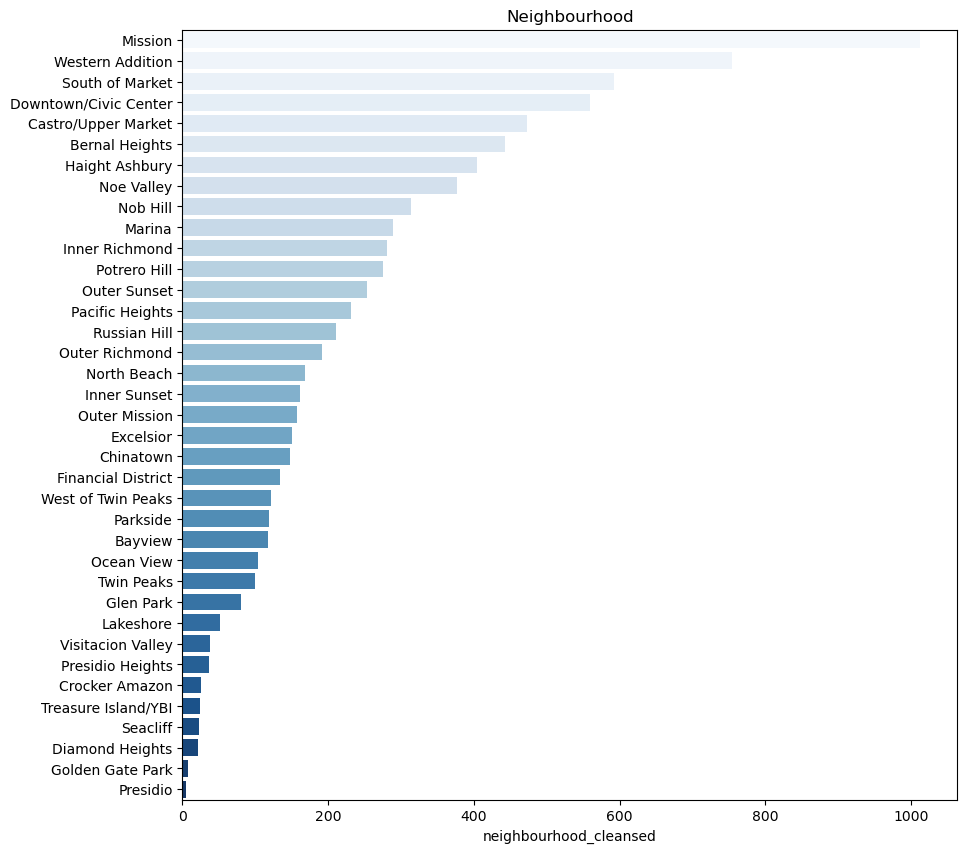

In [2748]:
# Plot all neighbourhoods
plt.figure(figsize=(10,10))
plt.title("Neighbourhood", size=12, color="Black")
sns.barplot(x=listings['neighbourhood_cleansed'].value_counts(), 
            y=listings['neighbourhood_cleansed'].value_counts().index, palette="Blues")
plt.show()

array([[<AxesSubplot:title={'center':'review_scores_rating'}>,
        <AxesSubplot:title={'center':'review_scores_accuracy'}>,
        <AxesSubplot:title={'center':'review_scores_cleanliness'}>],
       [<AxesSubplot:title={'center':'review_scores_checkin'}>,
        <AxesSubplot:title={'center':'review_scores_communication'}>,
        <AxesSubplot:title={'center':'review_scores_location'}>],
       [<AxesSubplot:title={'center':'review_scores_value'}>,
        <AxesSubplot:title={'center':'reviews_per_month'}>,
        <AxesSubplot:>]], dtype=object)

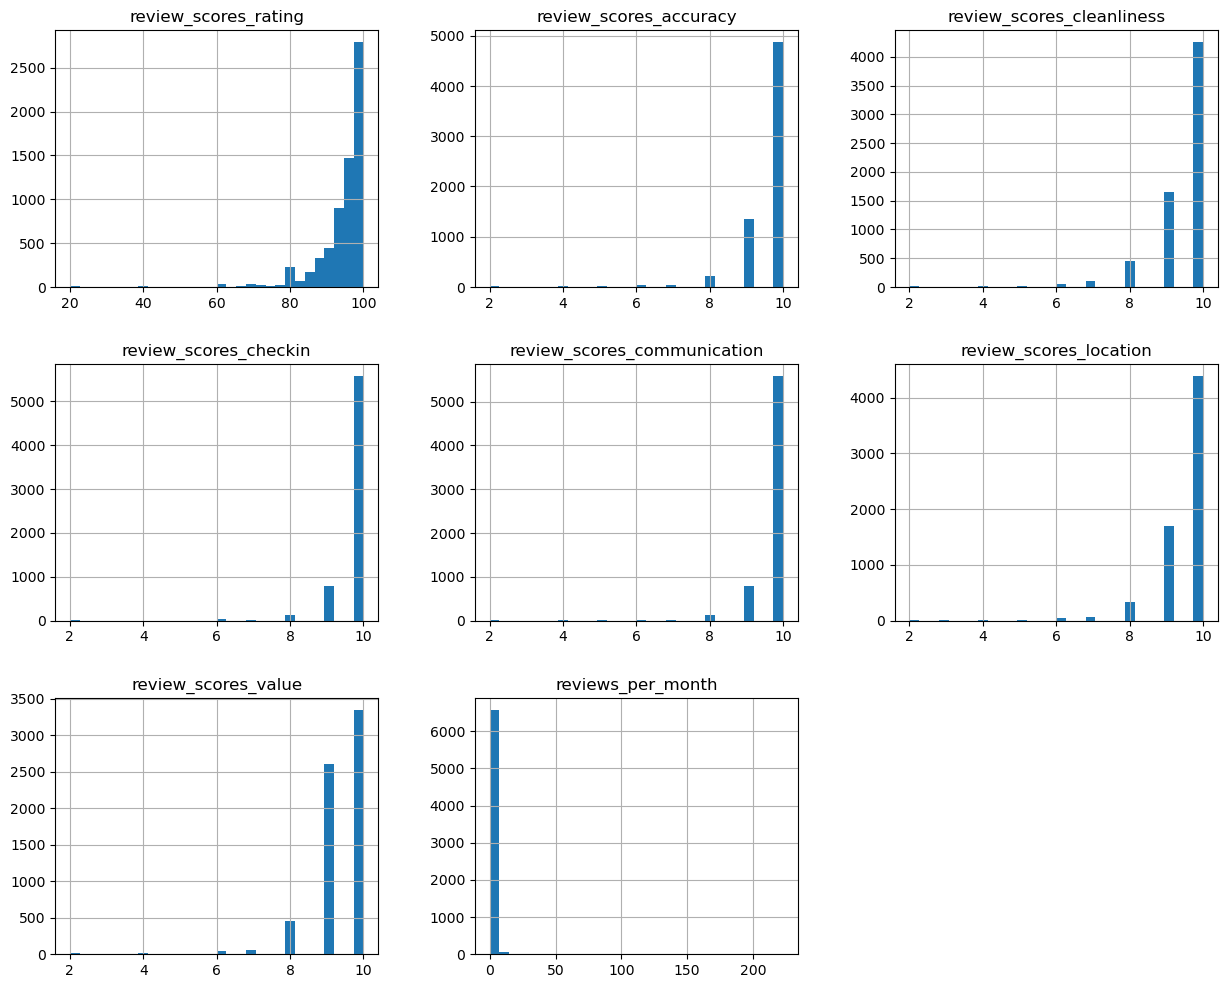

In [2749]:
# Display property reviews
reviews = listings.loc[:, listings.columns[listings.columns.str.startswith('review')]].astype(float)
reviews.hist(bins = 30, figsize = (15,12))

In [2750]:
# Plot bar chart
def bar_chart(column: str):
    count = listings[column].value_counts()
    fig = plt.figure(figsize=(14, 5))
    bar_ax = sns.barplot(x=count.keys(),y=count, palette="Blues") 
    for i in bar_ax.containers:
        bar_ax.bar_label(i,fontsize=10)
    plt.xticks(rotation = 85, fontsize = 12)
    plt.xlabel(f"{column}",  fontsize = 12)
    plt.ylabel("count", fontsize = 12)
    plt.title(f"{column}", fontsize = 14)
    plt.grid()
    plt.show()

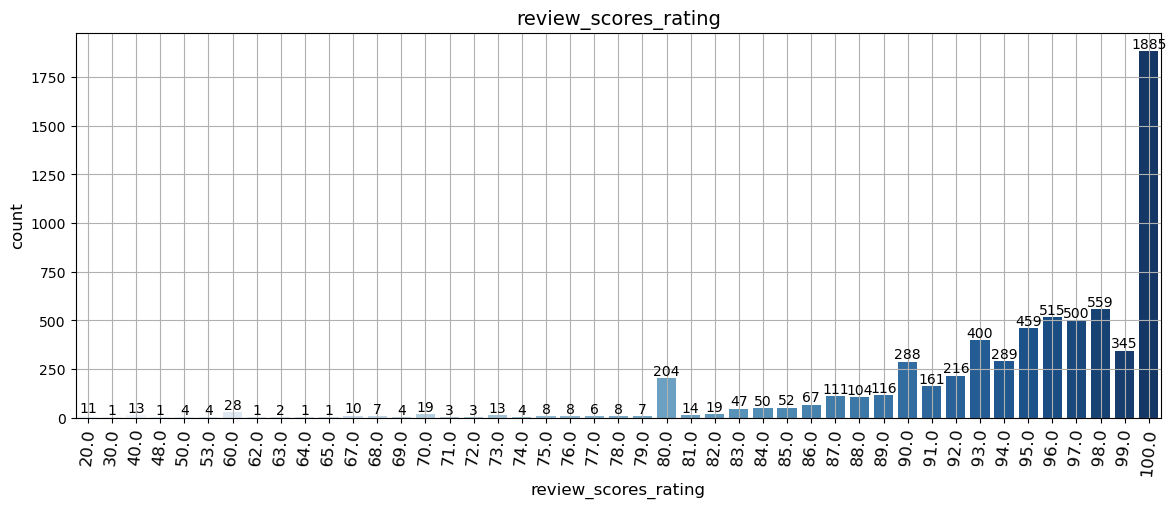

In [2751]:
# Display property rating score
bar_chart(column = "review_scores_rating")

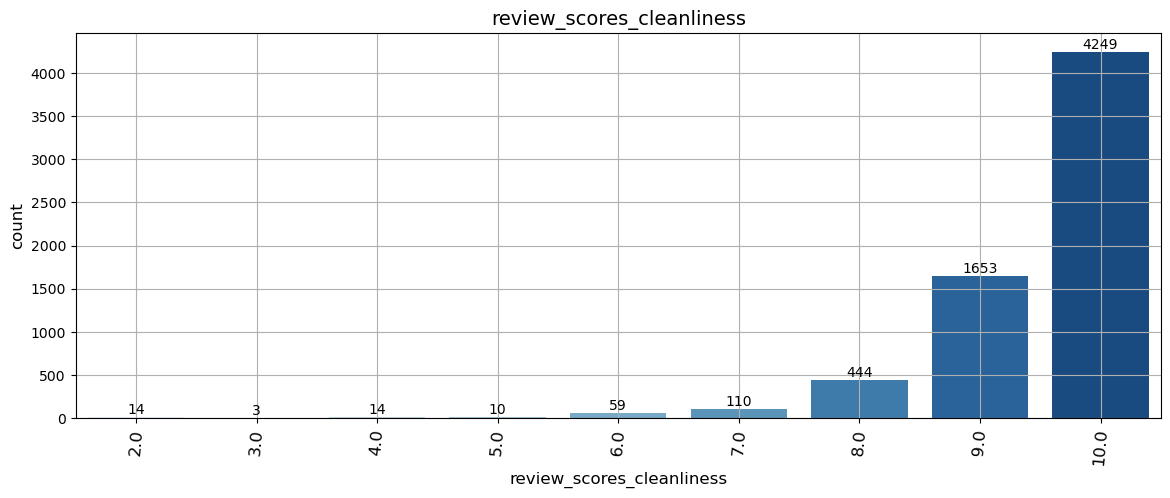

In [2752]:
# Display property cleaniness score
bar_chart(column = "review_scores_cleanliness")

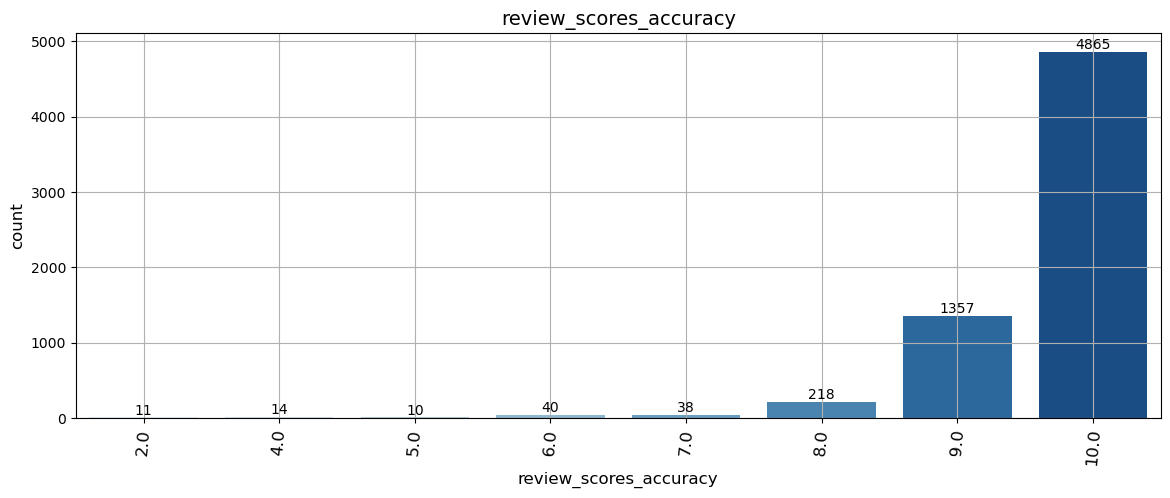

In [2753]:
# Display property listing accuracy
bar_chart(column="review_scores_accuracy")

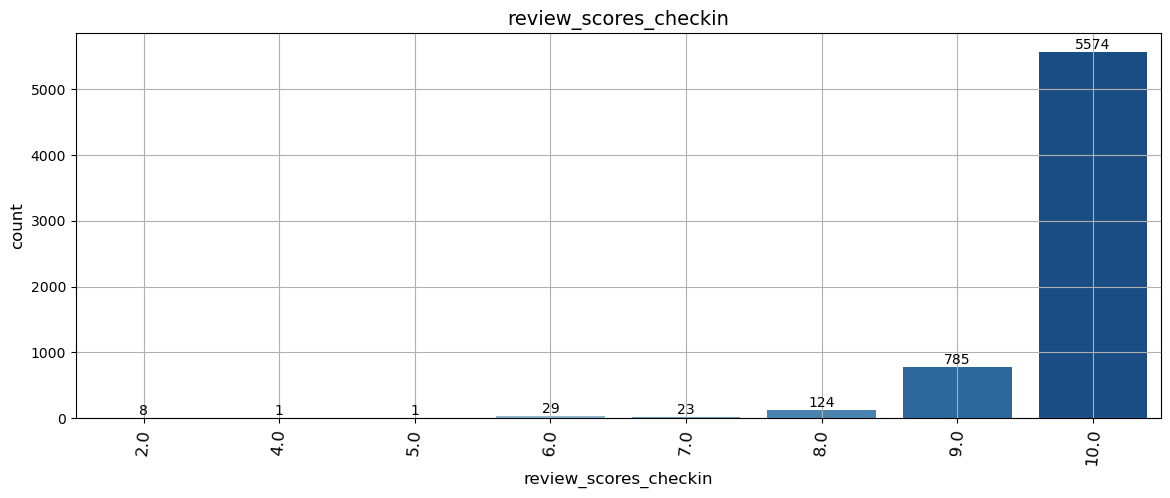

In [2754]:
# Display property checkin time accuracy score
bar_chart(column = "review_scores_checkin")

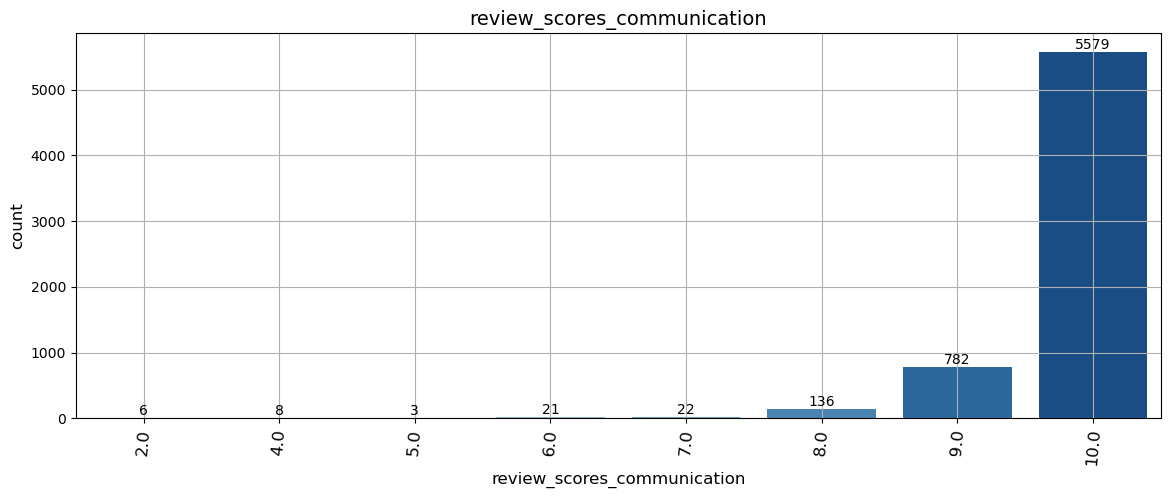

In [2755]:
# Display owner comminucation rating
bar_chart(column="review_scores_communication")

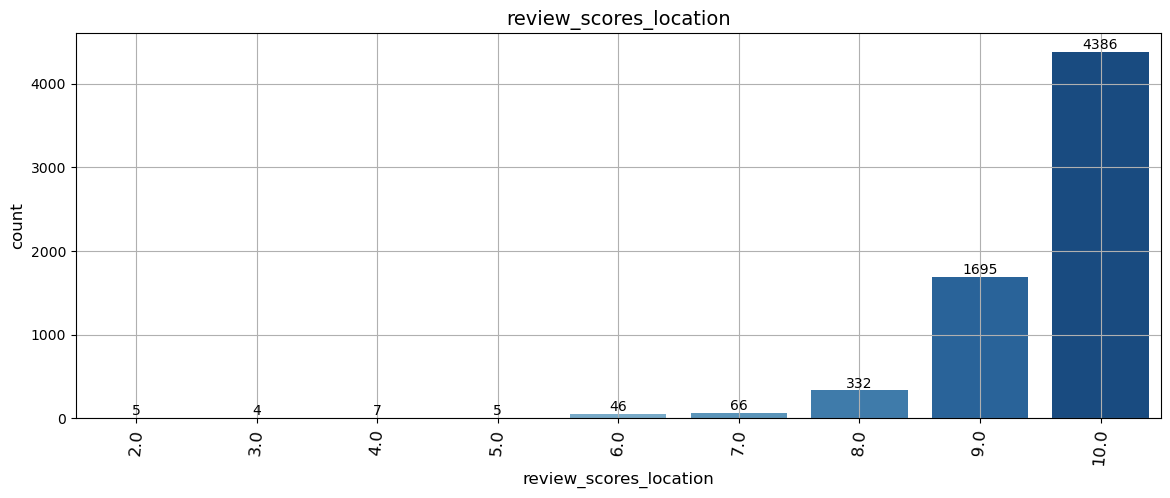

In [2756]:
# Display property location rating
bar_chart(column="review_scores_location")

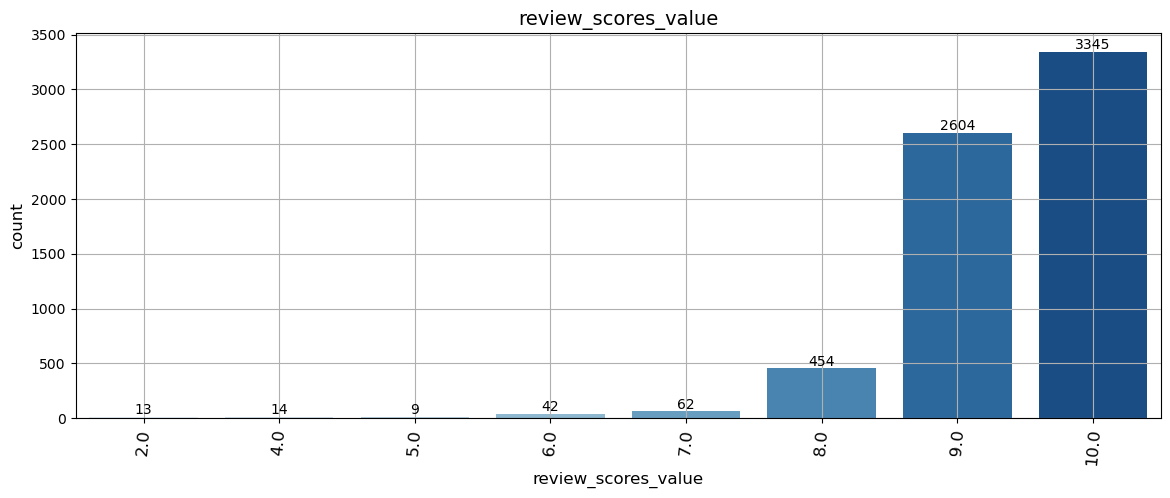

In [2757]:
# Display property score
bar_chart(column="review_scores_value")

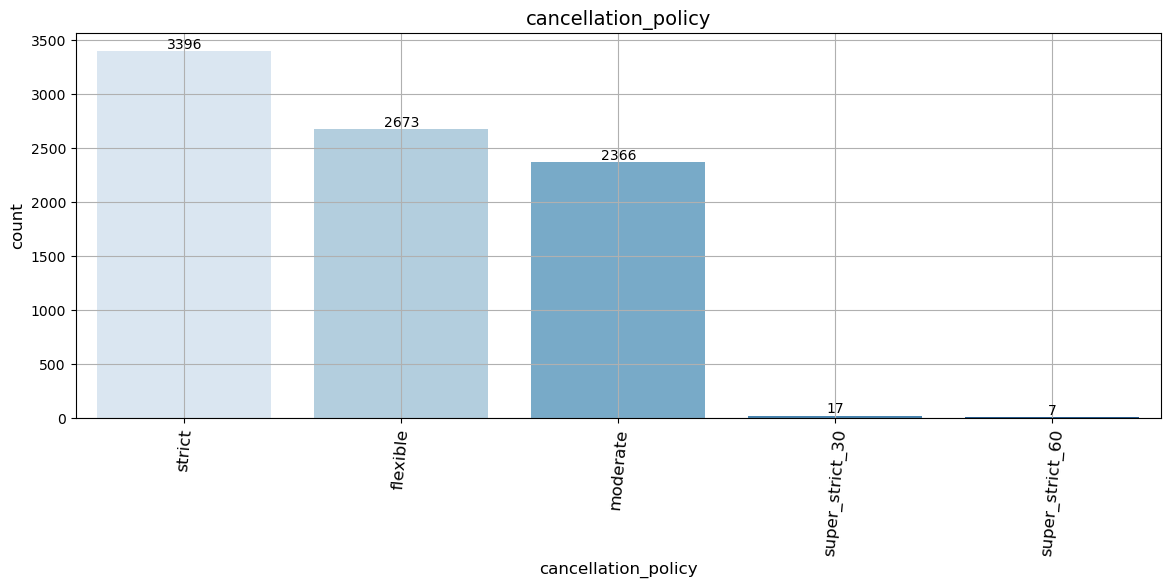

In [2758]:
# Display property cancellation policy
bar_chart(column="cancellation_policy")

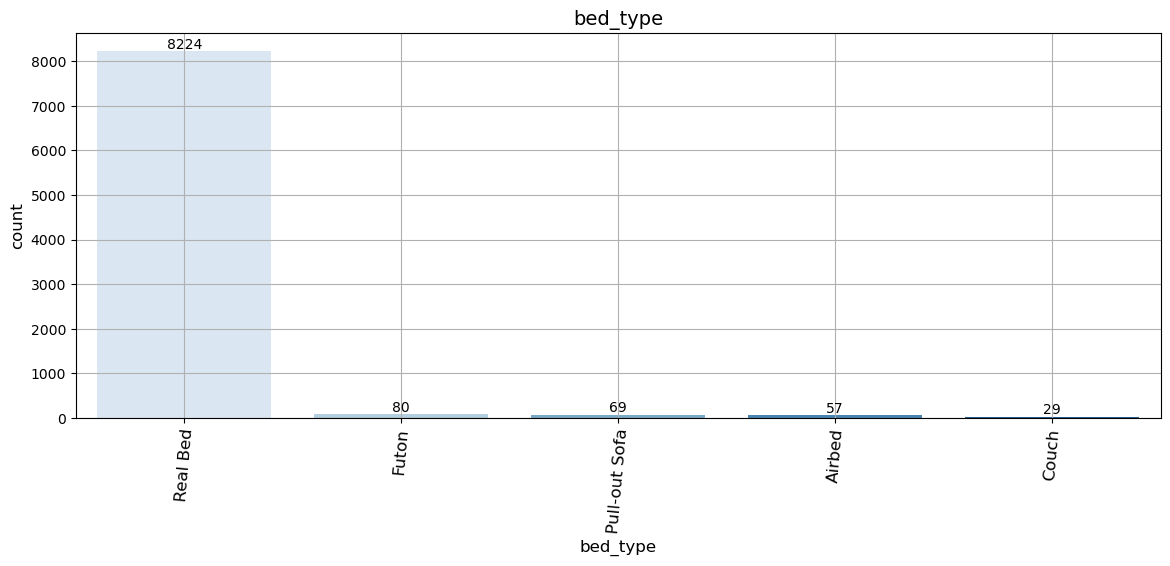

In [2759]:
# Display property bed type count
bar_chart(column="bed_type")

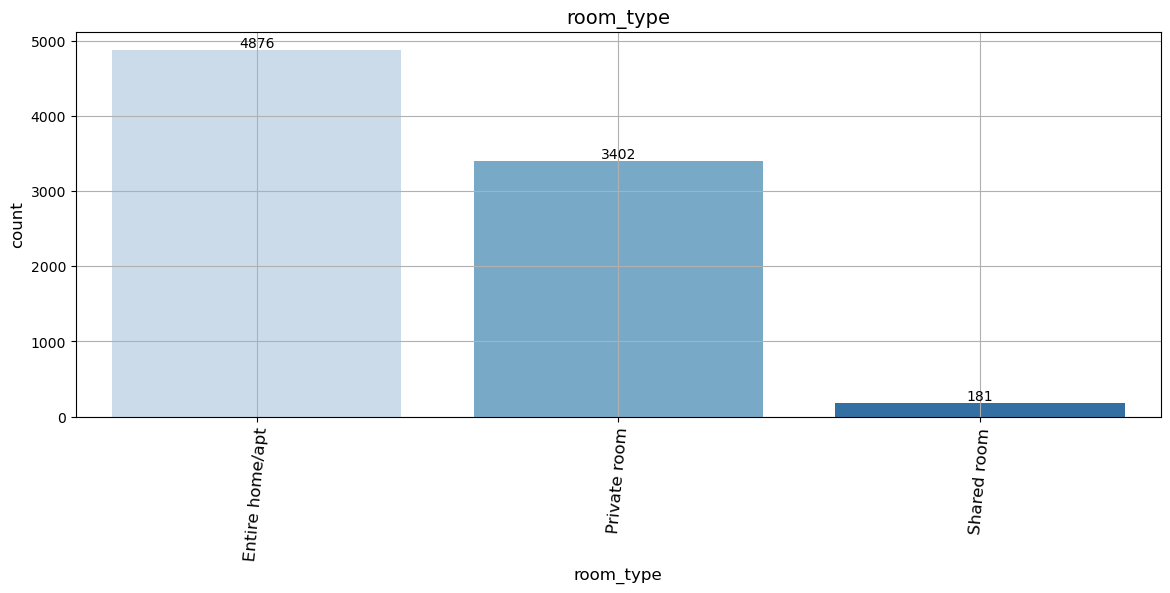

In [2760]:
# Display room type in the property
bar_chart(column="room_type")

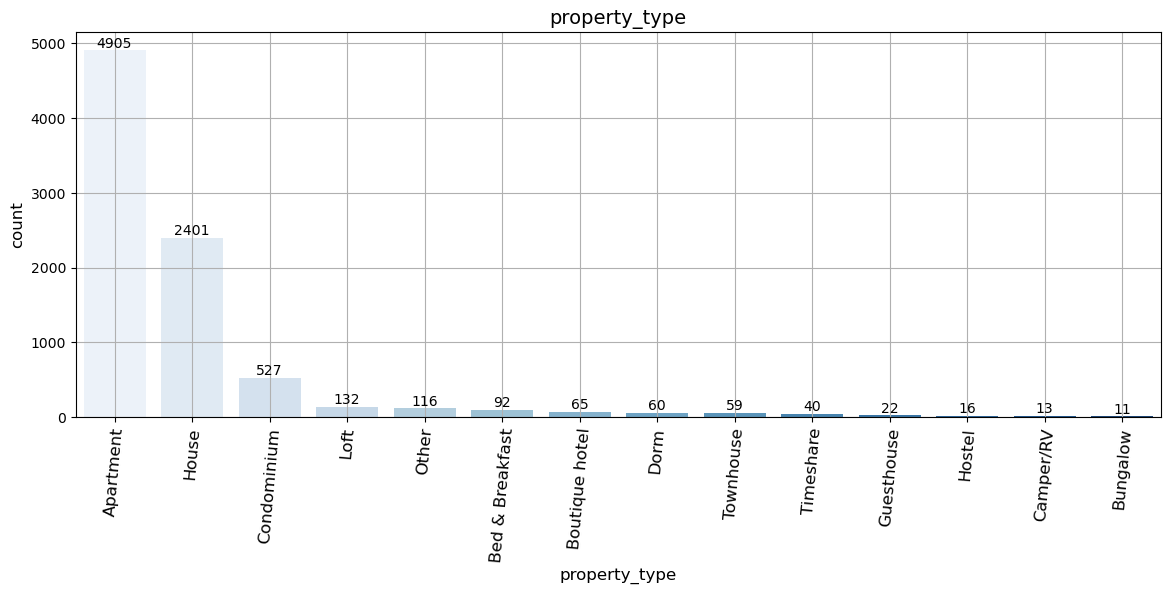

In [2761]:
# Display various property types
bar_chart(column="property_type")

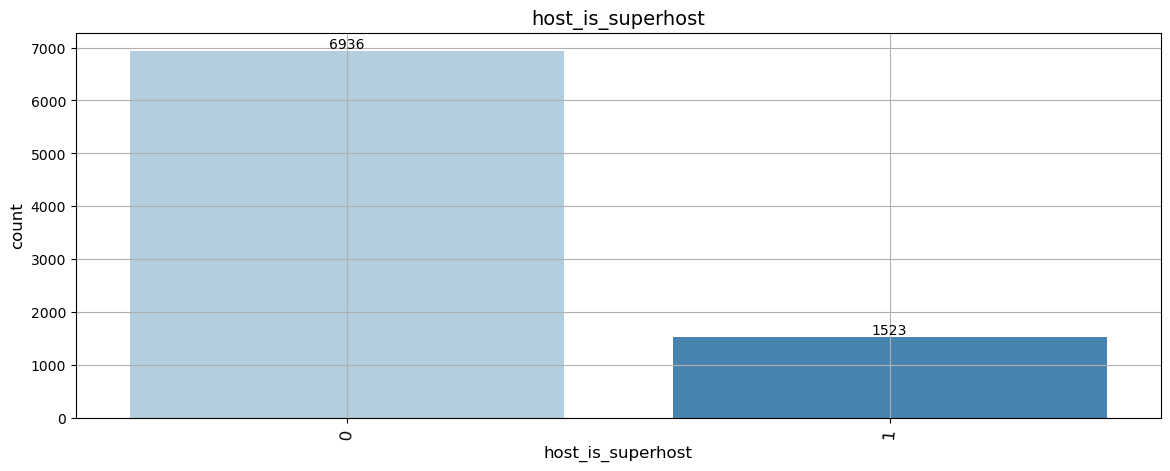

In [2762]:
# Display property owner status - whether owner is a superhost
bar_chart(column="host_is_superhost")

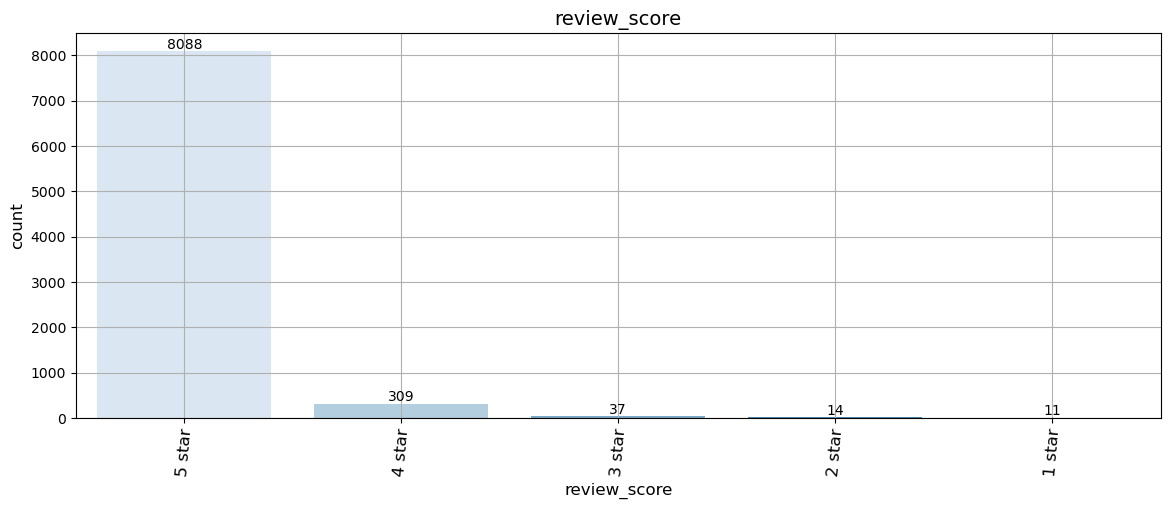

In [2763]:
# Assign 5-star rating for the property
listings['review_score'] = np.where(listings['review_scores_rating']<=20, '1 star',
            np.where((listings['review_scores_rating'] > 20) & (listings['review_scores_rating'] <= 40), '2 star',
            np.where((listings['review_scores_rating'] > 40) & (listings['review_scores_rating'] <= 60), '3 star', 
            np.where((listings['review_scores_rating'] > 60) & (listings['review_scores_rating'] <= 80), '4 star',
                            '5 star'))))
bar_chart(column = "review_score")

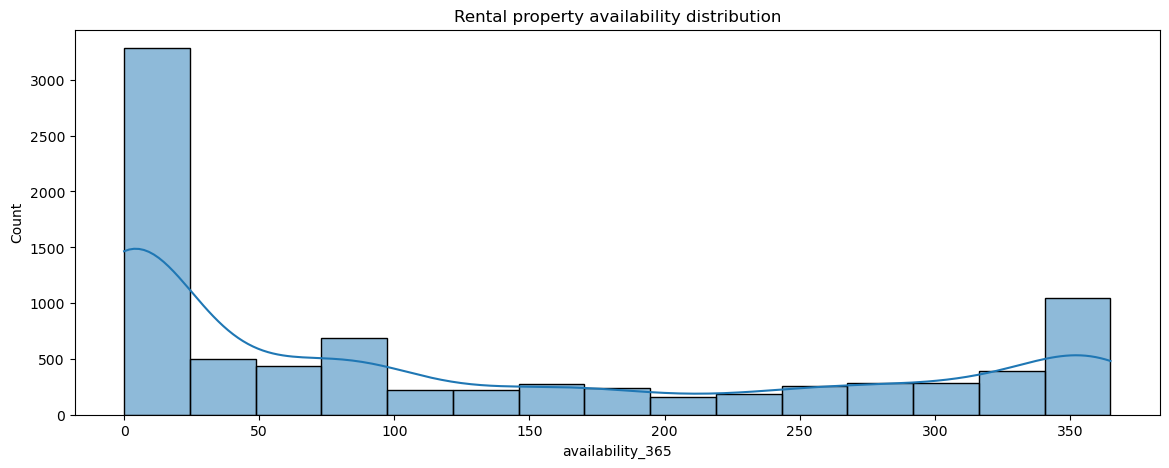

In [2764]:
# Display property availability
plt.figure(figsize=(14,5))
sns.histplot(data=listings, x='availability_365', kde=True)
plt.title('Rental property availability distribution', fontsize=12);
plt.show()

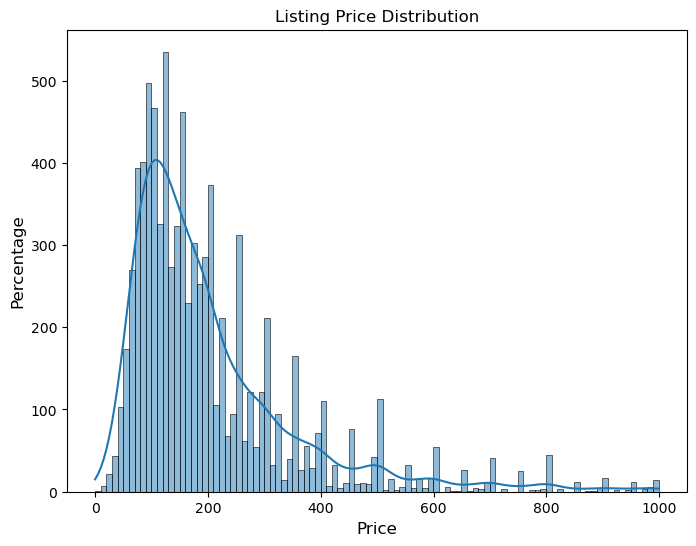

In [2765]:
# Display property price distribution
plt.figure(figsize=(8, 6))
sns.histplot(listings['price'], bins=100, kde=True)
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Price', fontsize=12)
plt.title('Listing Price Distribution', fontsize=12);

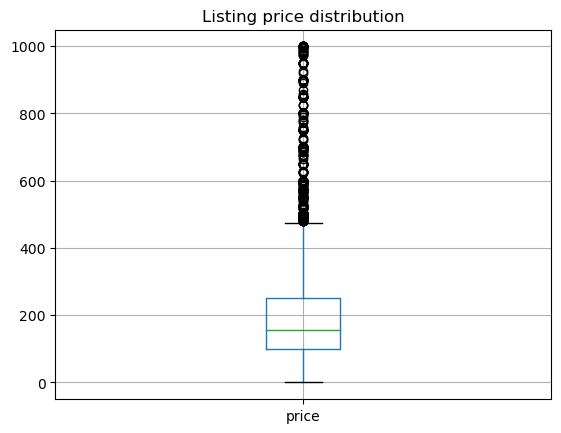

In [2766]:
# Display price boxplot
listings['price'] = pd.to_numeric(listings['price'])
plt.title('Listing price distribution', fontsize=12);
listings.boxplot(column=['price']);


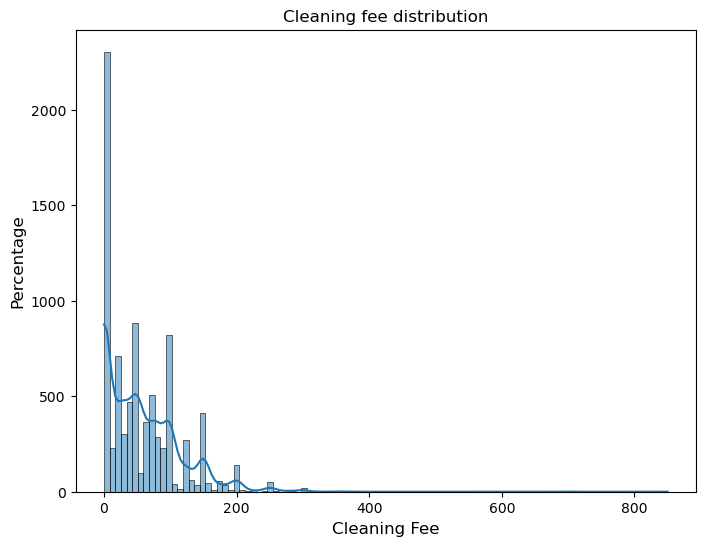

In [2767]:
# Display cleaning price distribution

plt.figure(figsize=(8, 6))
sns.histplot(listings['cleaning_fee'], bins=100, kde=True)
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Cleaning Fee', fontsize=12)
plt.title('Cleaning fee distribution', fontsize=12);

## Visualize bivariate relationship

In [2768]:
# Create a dataframe for multivariate analysis
#df_review = listings.filter(["price","cleaning_fee","beds","host_response_rate","minimum_nights","number_of_reviews",
#                             "neighbourhood_cleansed","cancellation_policy"],axis=1)
df_review= pd.DataFrame()
df_review[['price','cleaning_fee','beds','minimum_nights',
         'number_of_reviews','pets_allowed','instant_bookable',
         'host_is_superhost']] = listings[['price','cleaning_fee','beds','minimum_nights',
                                           'number_of_reviews','pets_allowed',
                                            'instant_bookable','host_is_superhost']].astype(int)

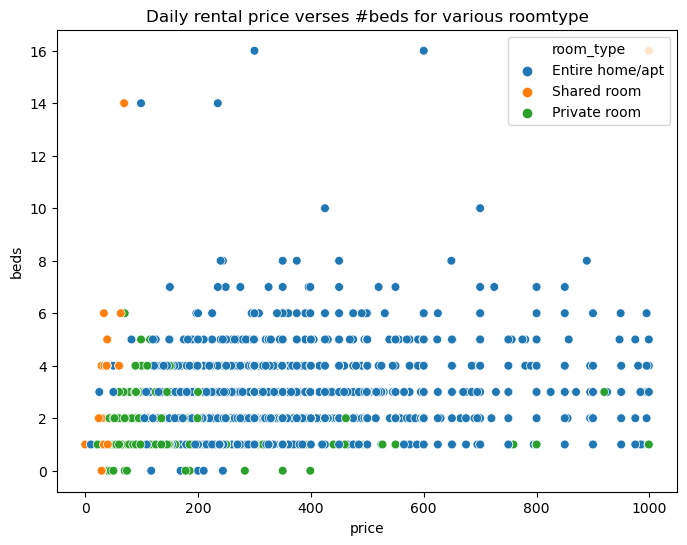

In [2769]:
# Visualize relationship between daily rental price verses #beds
plt.figure(figsize=(8,6))
plt.title("Daily rental price verses #beds for various roomtype", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.beds, hue=listings.room_type, s=40);

<AxesSubplot:title={'center':'Daily rental price verses #beds'}>

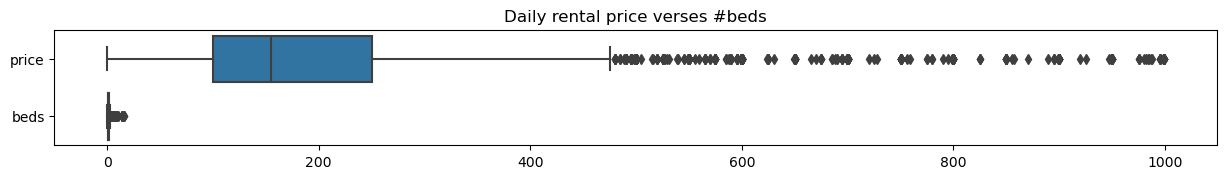

In [2770]:
# Visualize relationship between daily rental price verses #beds
figure = plt.figure(figsize=(15,1.5))
plt.title("Daily rental price verses #beds", size=12, color="black")
sns.boxplot(data=df_review[['price','beds']],orient='h')

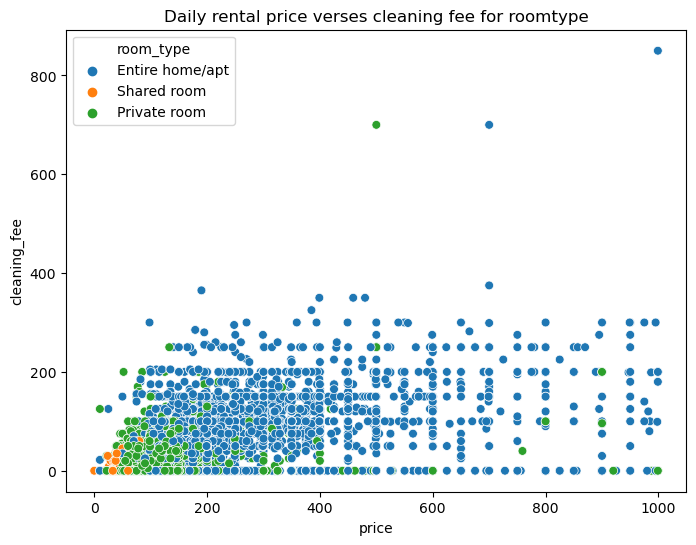

In [2771]:
# Visualize relationship between daily rental price verses cleaning fee for all roomtypes
plt.figure(figsize=(8,6))
plt.title("Daily rental price verses cleaning fee for roomtype", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.cleaning_fee, hue=listings.room_type, s=40);

<AxesSubplot:title={'center':'Daily rental price verses cleaning fee'}>

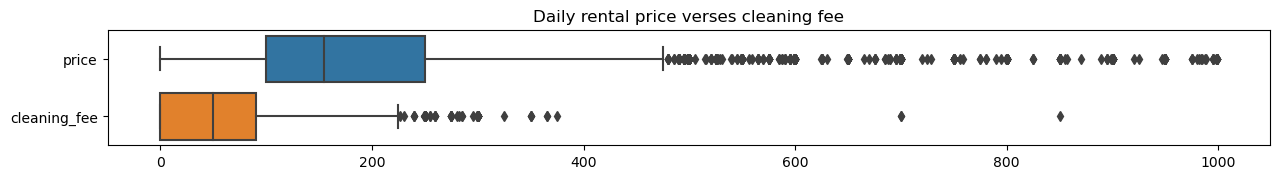

In [2772]:
# Visualize relationship between daily rental price verses cleaning fee
figure = plt.figure(figsize=(15,1.5))
plt.title("Daily rental price verses cleaning fee", size=12, color="black")
sns.boxplot(data=df_review[['price','cleaning_fee']],orient='h')

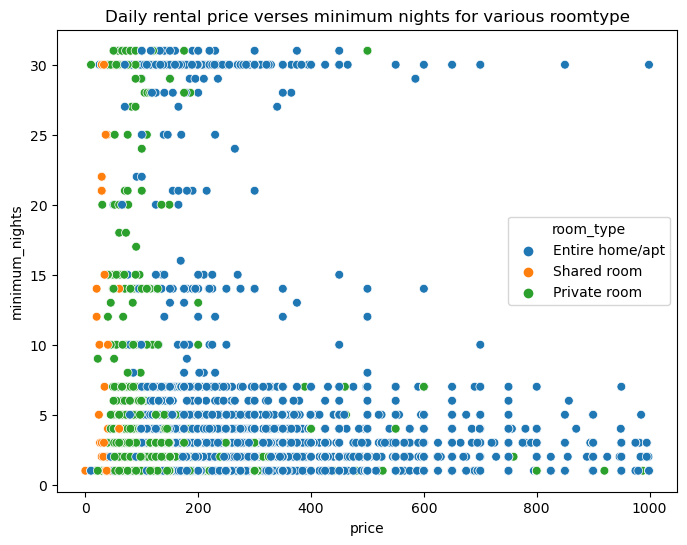

In [2773]:
# Visualize relationship between daily rental price verses minimum rental nights for all roomtypes
plt.figure(figsize=(8,6))
plt.title("Daily rental price verses minimum nights for various roomtype", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.minimum_nights, hue=listings.room_type, s=40);

<AxesSubplot:title={'center':'Daily rental price verses minimum nights'}>

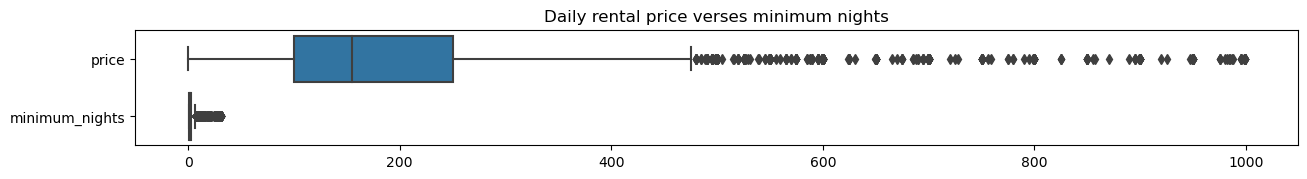

In [2774]:
# Visualize relationship between daily rental price verses minimum nights
figure = plt.figure(figsize=(15,1.5))
plt.title("Daily rental price verses minimum nights", size=12, color="black")
sns.boxplot(data=df_review[['price','minimum_nights']],orient='h')

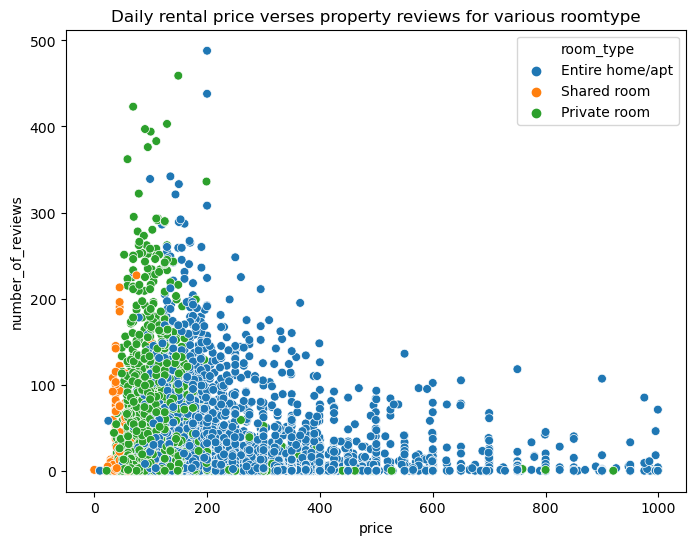

In [2775]:
# Visualize relationship between daily rental price verses reviews for all roomtypes
plt.figure(figsize=(8,6))
plt.title("Daily rental price verses property reviews for various roomtype", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings.room_type, s=40);

<AxesSubplot:title={'center':'Daily rental price verses property review'}>

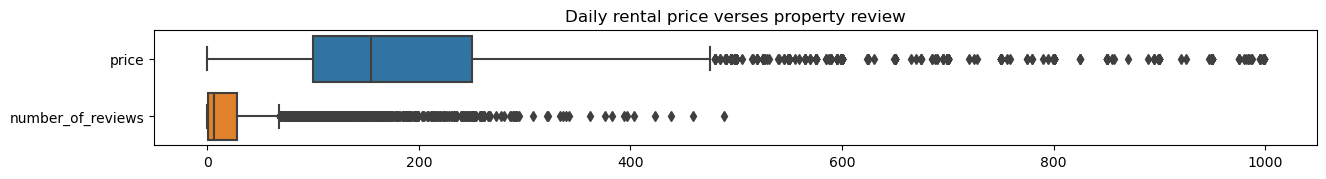

In [2776]:
# Visualize relationship between daily rental price verses property reviews
figure = plt.figure(figsize=(15,1.5))
plt.title("Daily rental price verses property review", size=12, color="black")
sns.boxplot(data=df_review[['price','number_of_reviews']],orient='h')

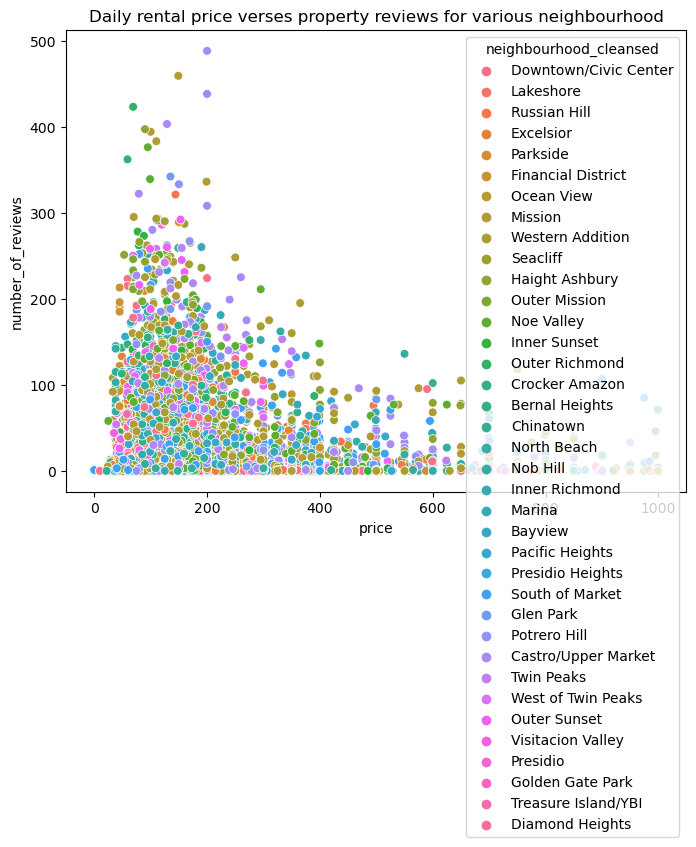

In [2777]:
# Visualize relationship between daily rental price verses reviews for all neighbourhood
plt.figure(figsize=(8,6))
plt.title("Daily rental price verses property reviews for various neighbourhood", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings.neighbourhood_cleansed, s=40);

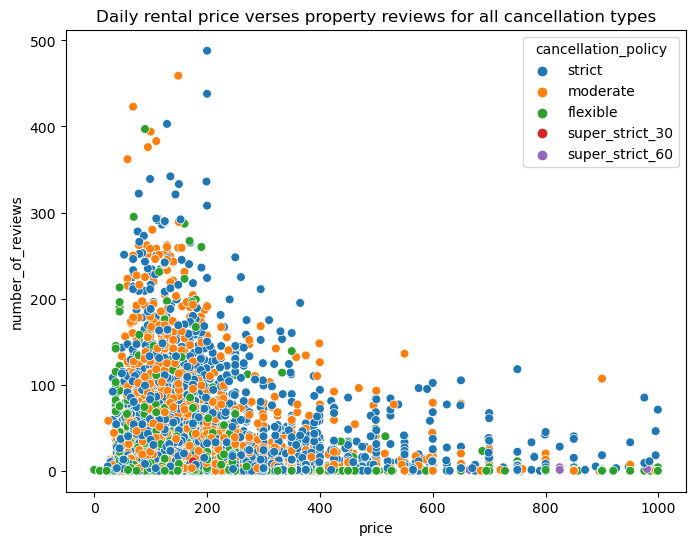

In [2778]:
# Visualize relationship between daily rental price verses cancellation policy
plt.figure(figsize=(8,6))
plt.title("Daily rental price verses property reviews for all cancellation types", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings.cancellation_policy, s=40);

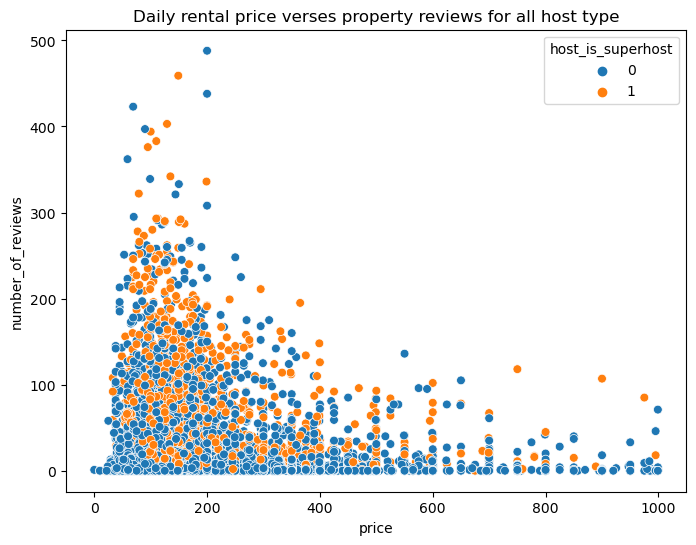

In [2779]:
# Visualize relationship between daily rental price verses reviews for all host type
plt.figure(figsize=(8,6))
plt.title("Daily rental price verses property reviews for all host type", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings.host_is_superhost, s=40);

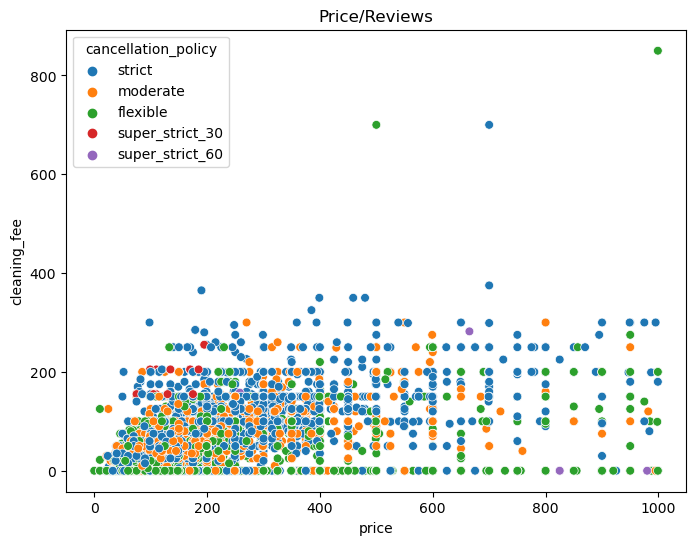

In [2780]:
# Visualize relationship between daily rental price verses cleaning fee for all cancellation type
plt.figure(figsize=(8,6))
plt.title("Price/Reviews", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.cleaning_fee, hue=listings.cancellation_policy, s=40);

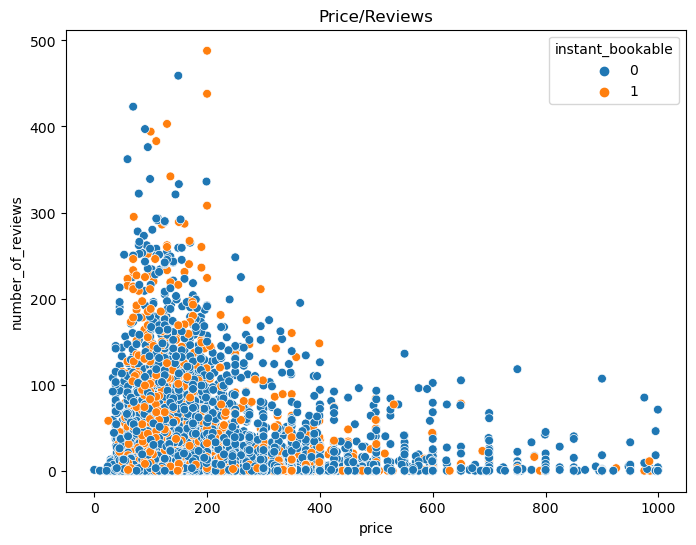

In [2781]:
# Visualize relationship between daily rental price verses property reviews for instant bookable status
plt.figure(figsize=(8,6))
plt.title("Price/Reviews", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings.instant_bookable, s=40);

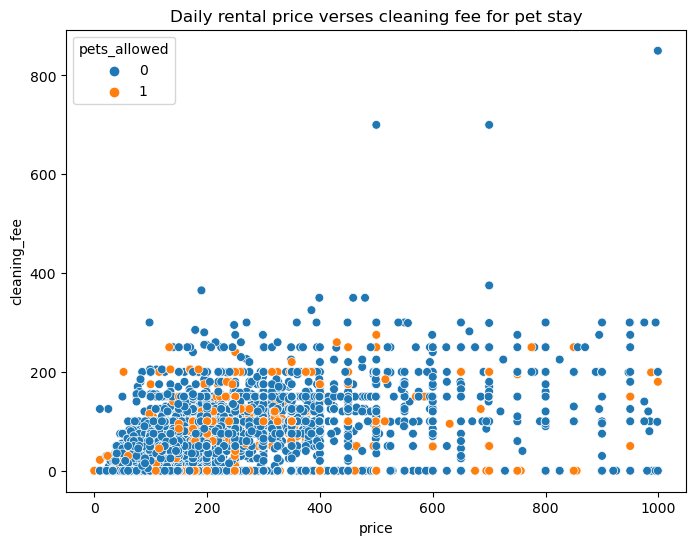

In [2782]:
# Visualize relationship between daily rental price verses cleaning fee for pet stay in property
plt.figure(figsize=(8,6))
plt.title("Daily rental price verses cleaning fee for pet stay", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.cleaning_fee, hue=listings.pets_allowed, s=40);

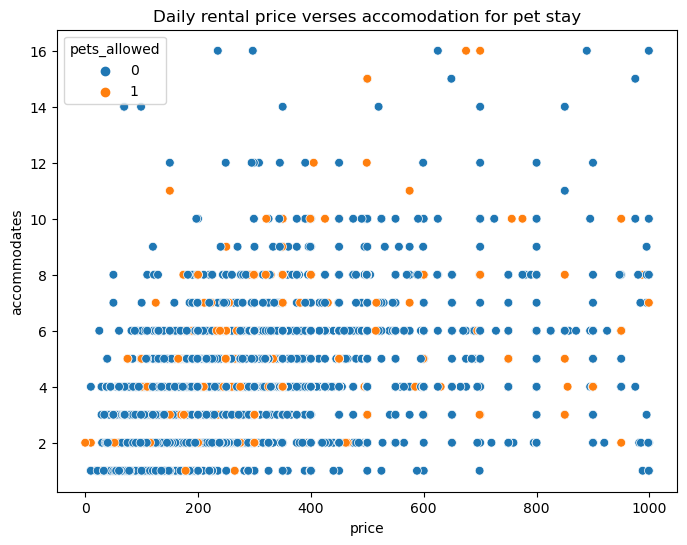

In [2783]:
# Visualize relationship between daily rental price verses accomodation count for pet stay in property
plt.figure(figsize=(8,6))
plt.title("Daily rental price verses accomodation for pet stay", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.accommodates, hue=listings.pets_allowed, s=40);

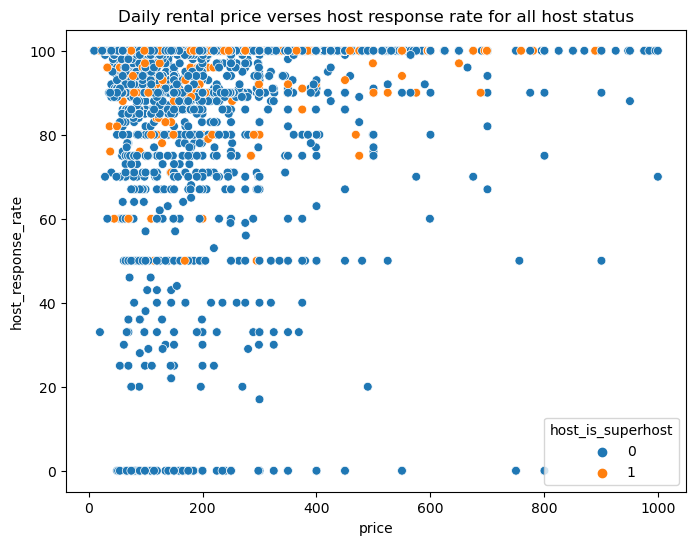

In [2784]:
# Visualize relationship between daily rental price verses host response rate for pet stay in property
plt.figure(figsize=(8,6))
plt.title("Daily rental price verses host response rate for all host status", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.host_response_rate, hue=listings.host_is_superhost,s=40);

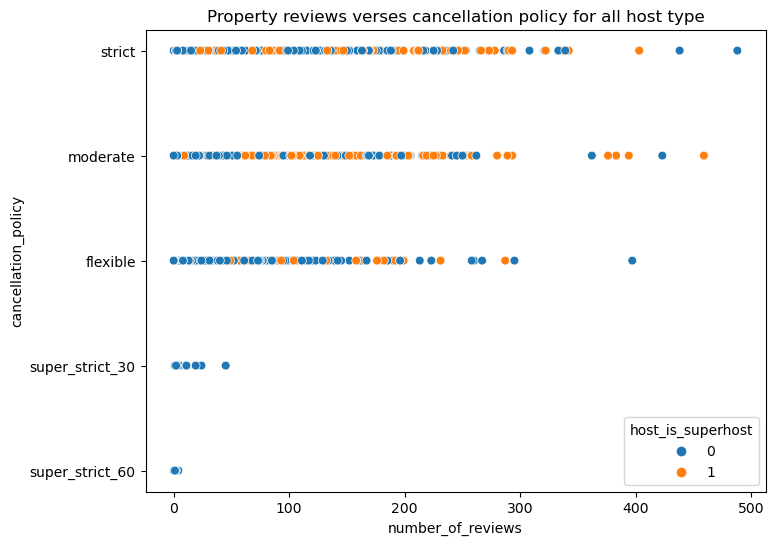

In [2785]:
# Visualize relationship between property reviews verses cancellation policy for every host status
plt.figure(figsize=(8,6))
plt.title("Property reviews verses cancellation policy for all host type", size=12, color="black")
sns.scatterplot(x=listings.number_of_reviews, y=listings.cancellation_policy, hue=listings.host_is_superhost, s=40);

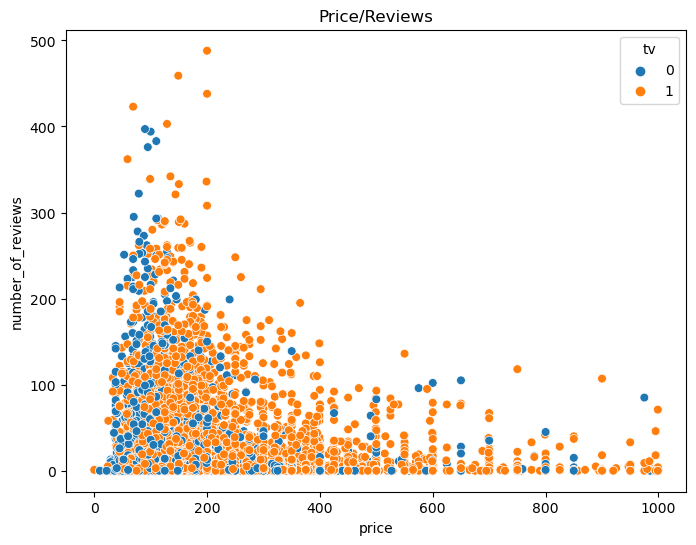

In [2786]:
# Visualize relationship between daily rental price verses property reviews for property with TV
plt.figure(figsize=(8,6))
plt.title("Price/Reviews", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings.tv, s=40);

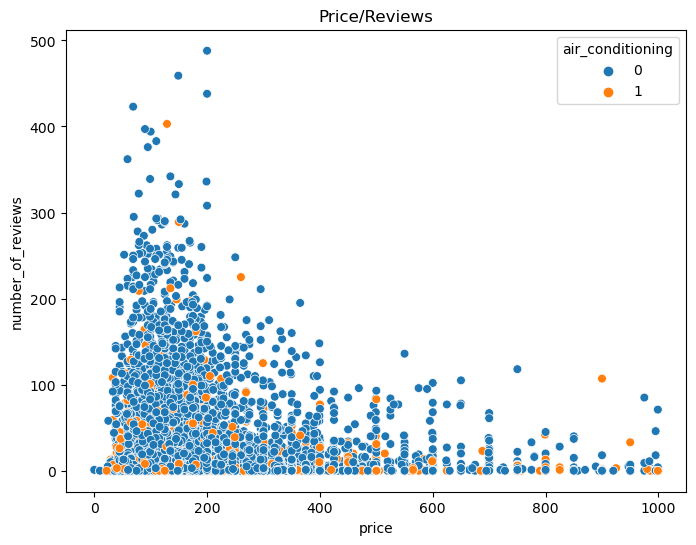

In [2787]:
# Visualize relationship between daily rental price verses property reviews for property with AC
plt.figure(figsize=(8,6))
plt.title("Price/Reviews", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings.air_conditioning, s=40);

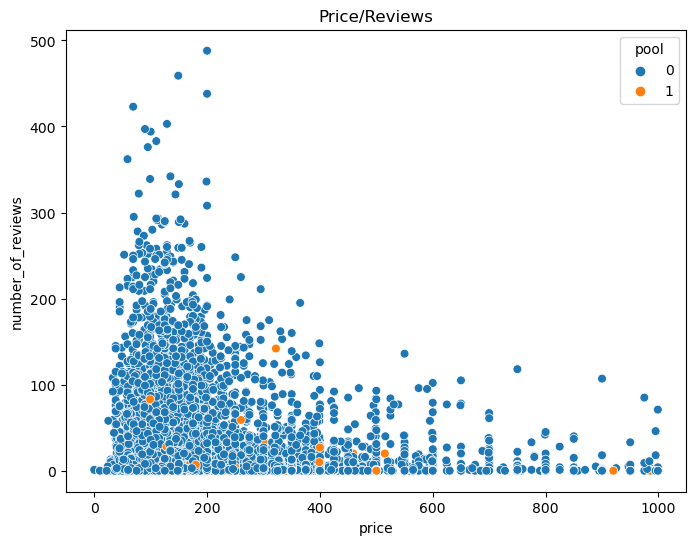

In [2788]:
# Visualize relationship between daily rental price verses property reviews for property with pool
plt.figure(figsize=(8,6))
plt.title("Price/Reviews", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings.pool, s=40);

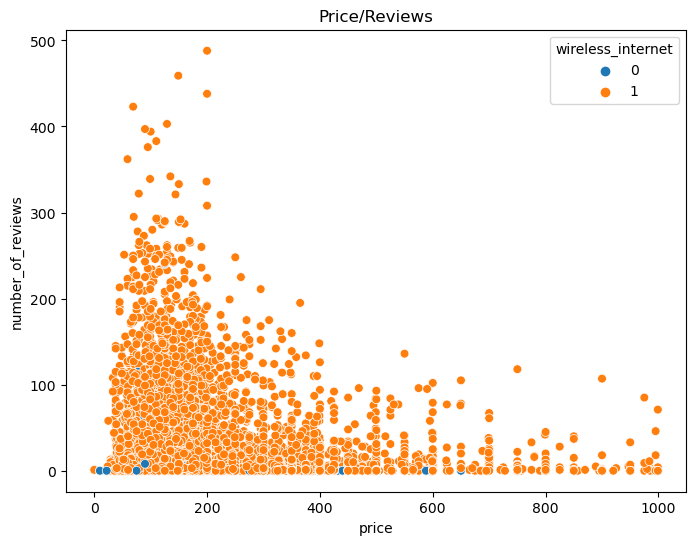

In [2789]:
# Visualize relationship between daily rental price verses property reviews for property with wifi
plt.figure(figsize=(8,6))
plt.title("Price/Reviews", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings.wireless_internet, s=40);

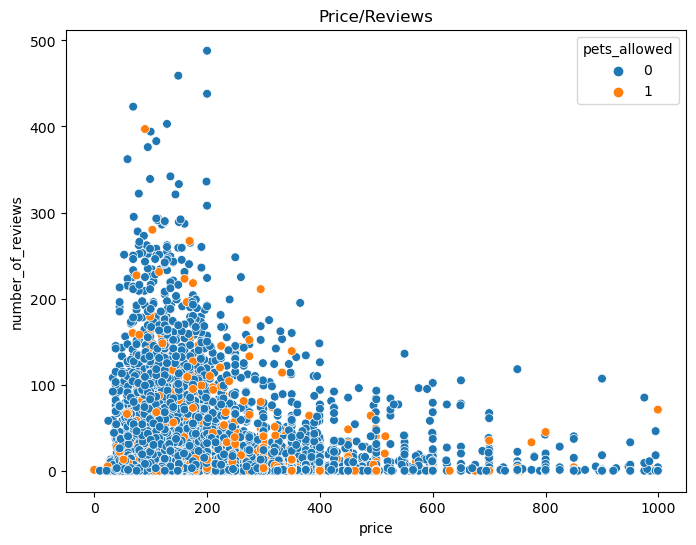

In [2790]:
# Visualize relationship between daily rental price verses property reviews for property with pets allowed
plt.figure(figsize=(8,6))
plt.title("Price/Reviews", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings.pets_allowed, s=40);

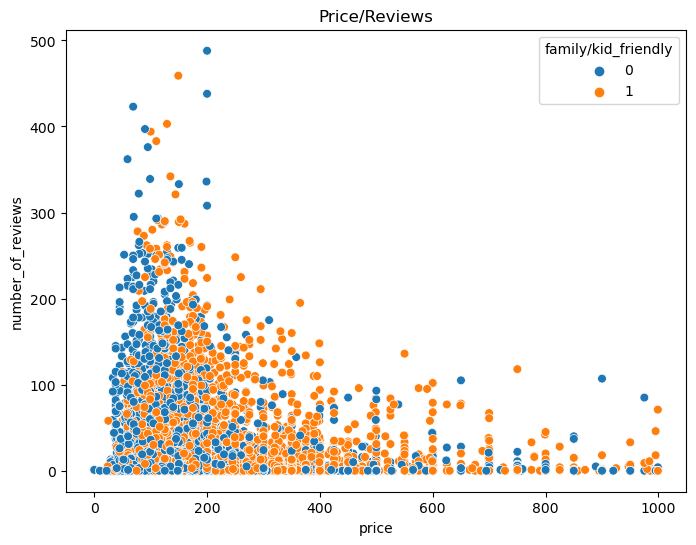

In [2791]:
# Visualize relationship between daily rental price verses property reviews for property with pets allowed
plt.figure(figsize=(8,6))
plt.title("Price/Reviews", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings['family/kid_friendly'], s=40);

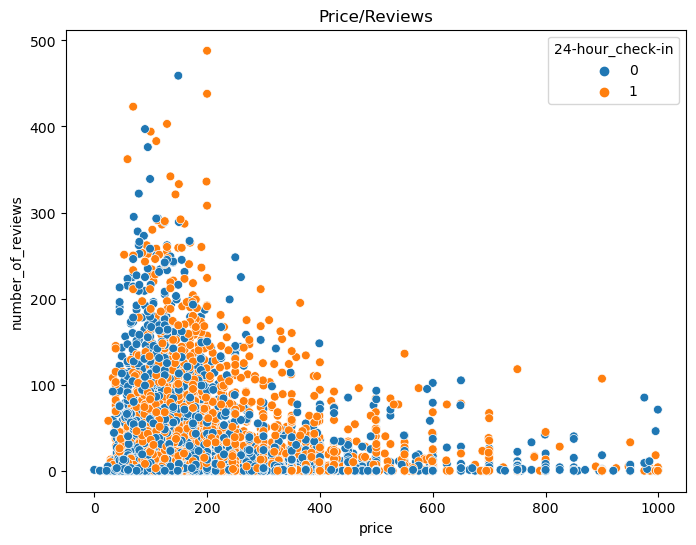

In [2792]:
# Visualize relationship between daily rental price verses property reviews for property with 24h checkin
plt.figure(figsize=(8,6))
plt.title("Price/Reviews", size=12, color="black")
sns.scatterplot(x=listings.price, y=listings.number_of_reviews, hue=listings['24-hour_check-in'], s=40);

[Text(0.5, 1.0, 'Correlation matrix for the features in the dataset')]

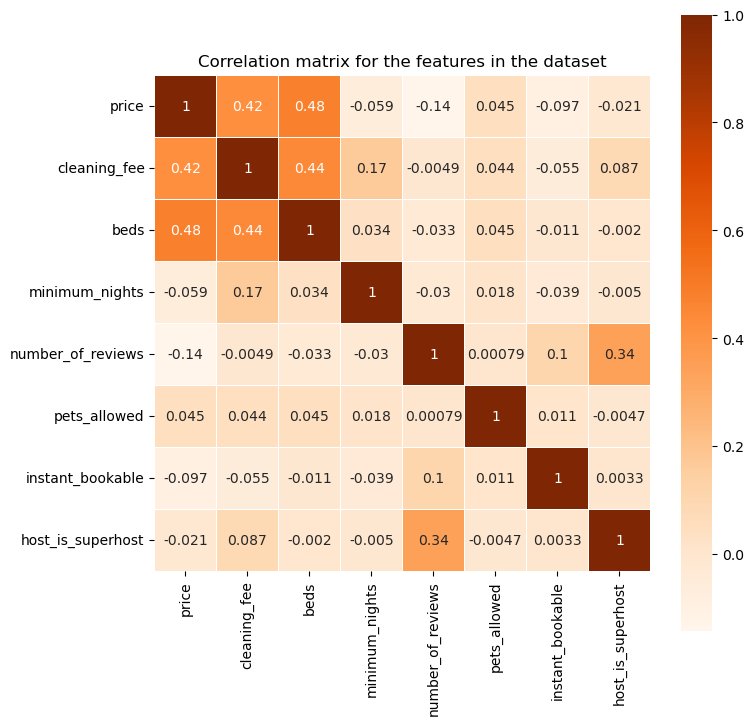

In [2793]:
# Correlation matrix
figure=plt.figure(figsize=(8,8))
figure=sns.heatmap(df_review.corr(), annot=True, cmap='Oranges', square=True, linewidth=0.5)
figure.set(title="Correlation matrix for the features in the dataset")

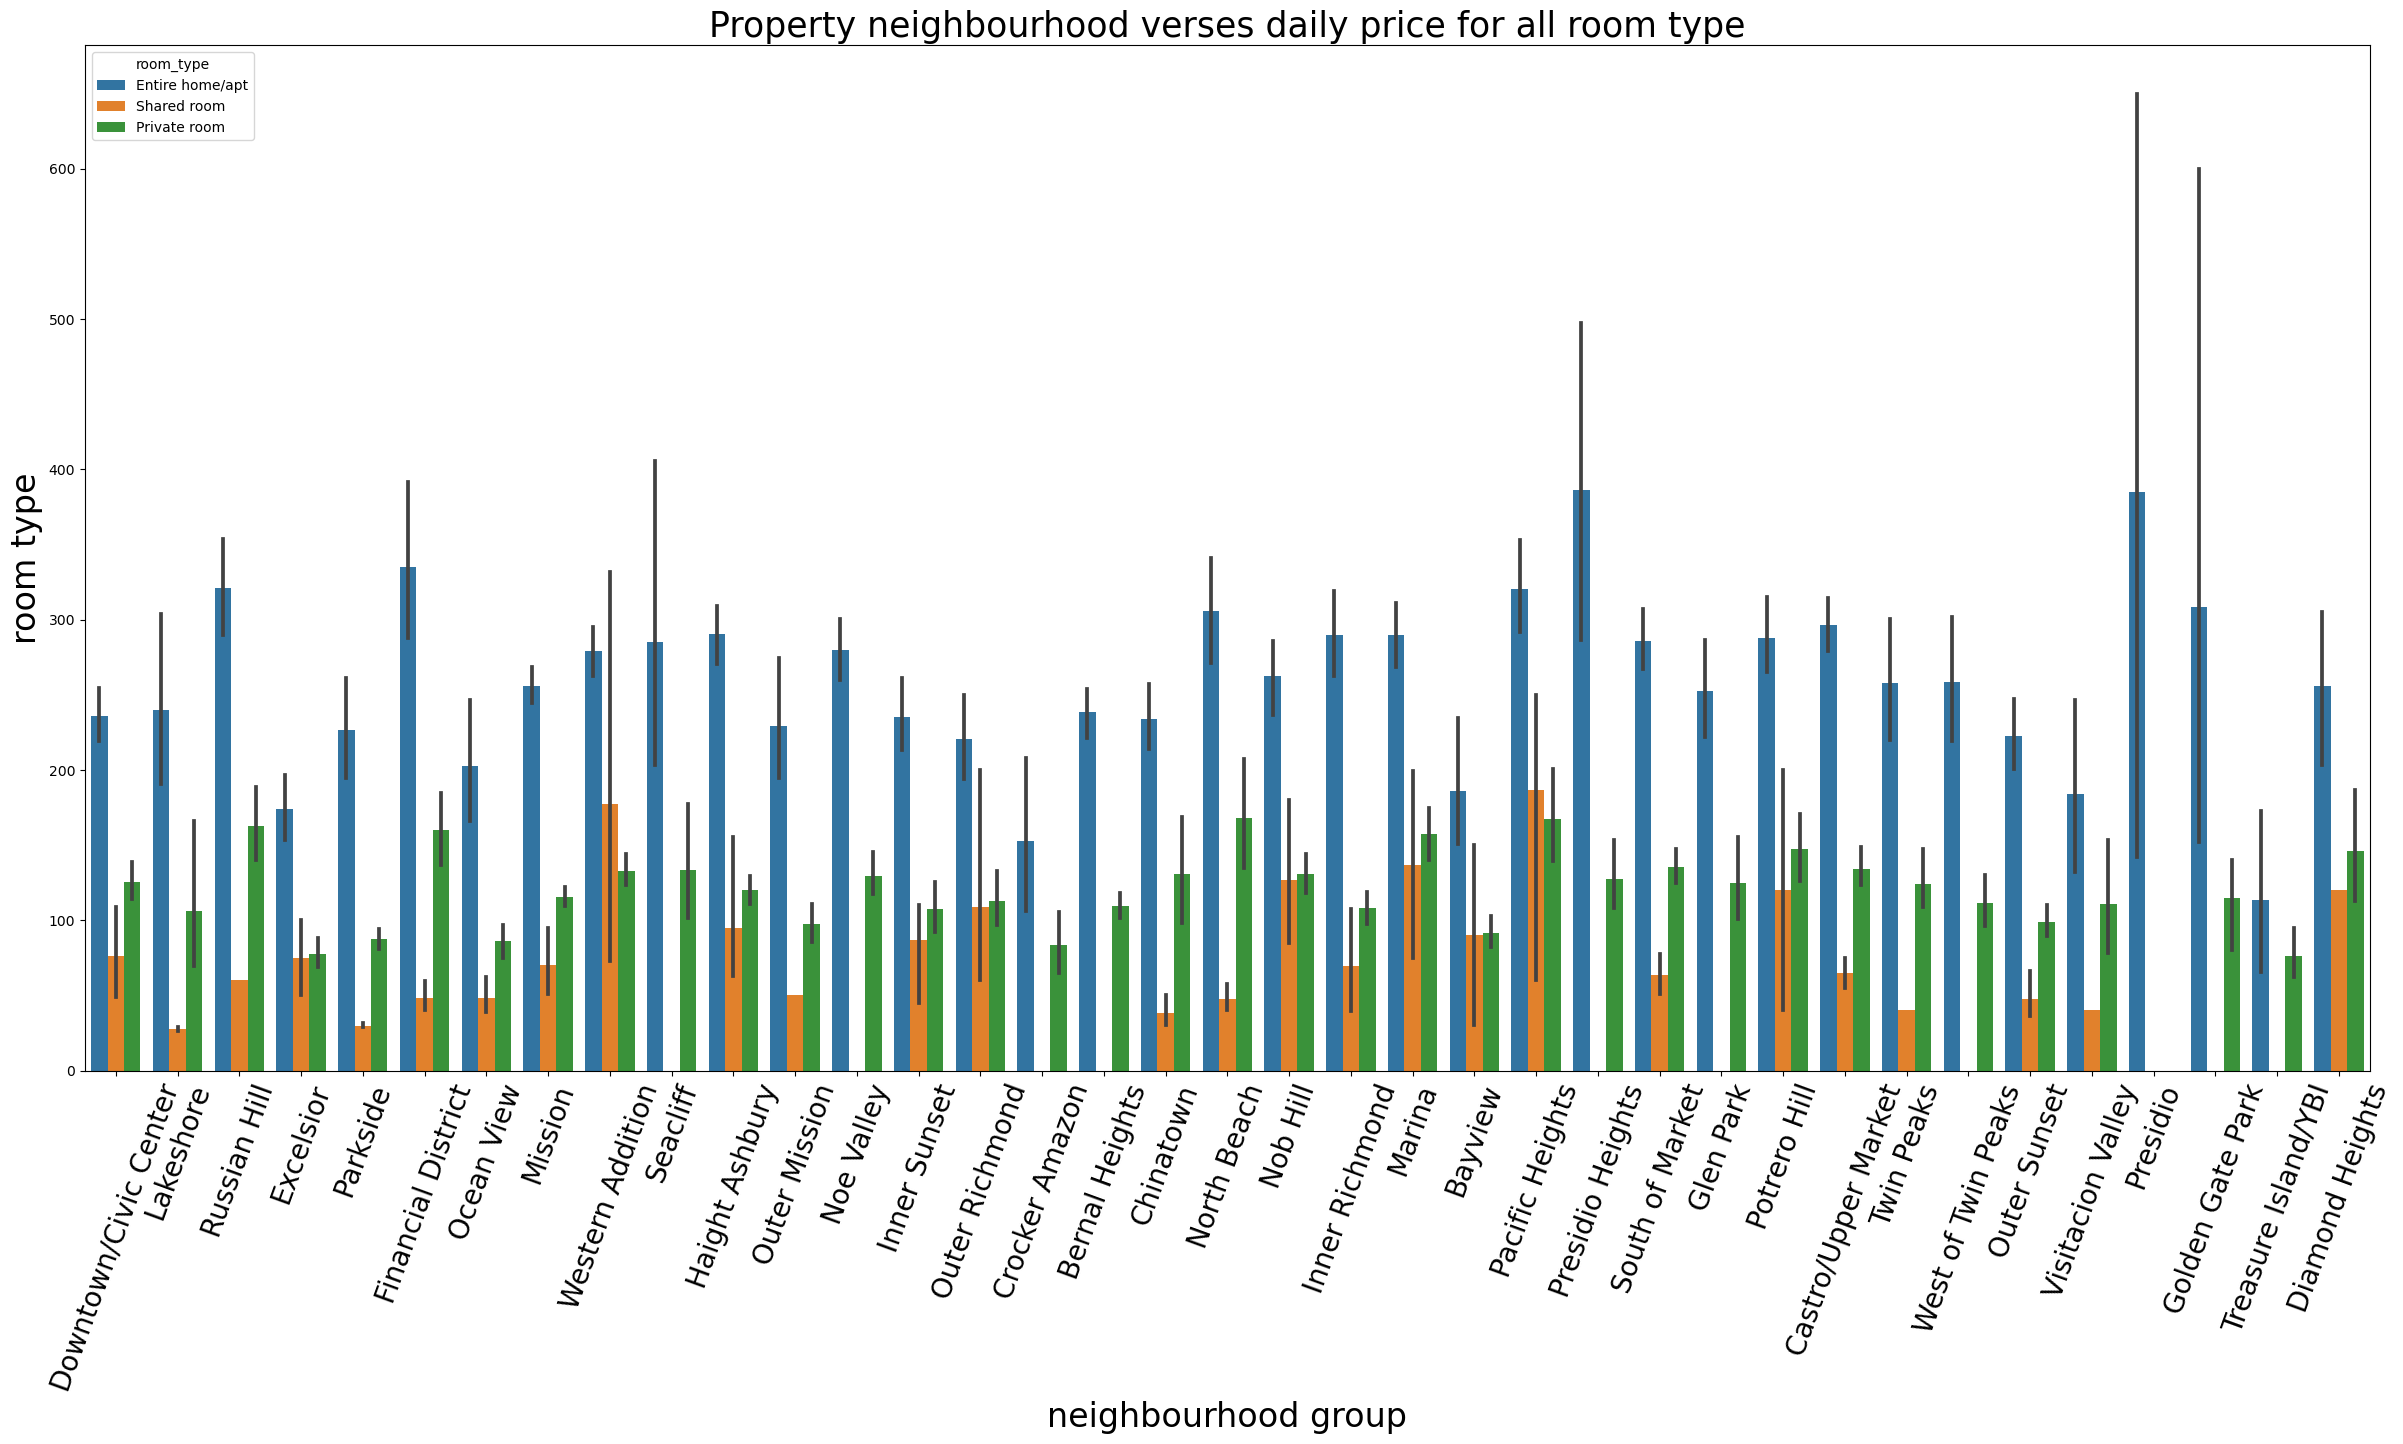

In [2794]:
# Visualize relationship between property neighbourhood verses daily price for every room type
plt.figure(figsize=(24, 14))
sns.barplot(data=listings, x='neighbourhood_cleansed', y='price', hue='room_type')
plt.xticks(rotation=70,fontsize=20)
plt.tight_layout()
plt.xlabel('neighbourhood group',fontsize=24)
plt.ylabel('room type',fontsize=24)
plt.title("Property neighbourhood verses daily price for all room type", size=25, color="black")
plt.show()

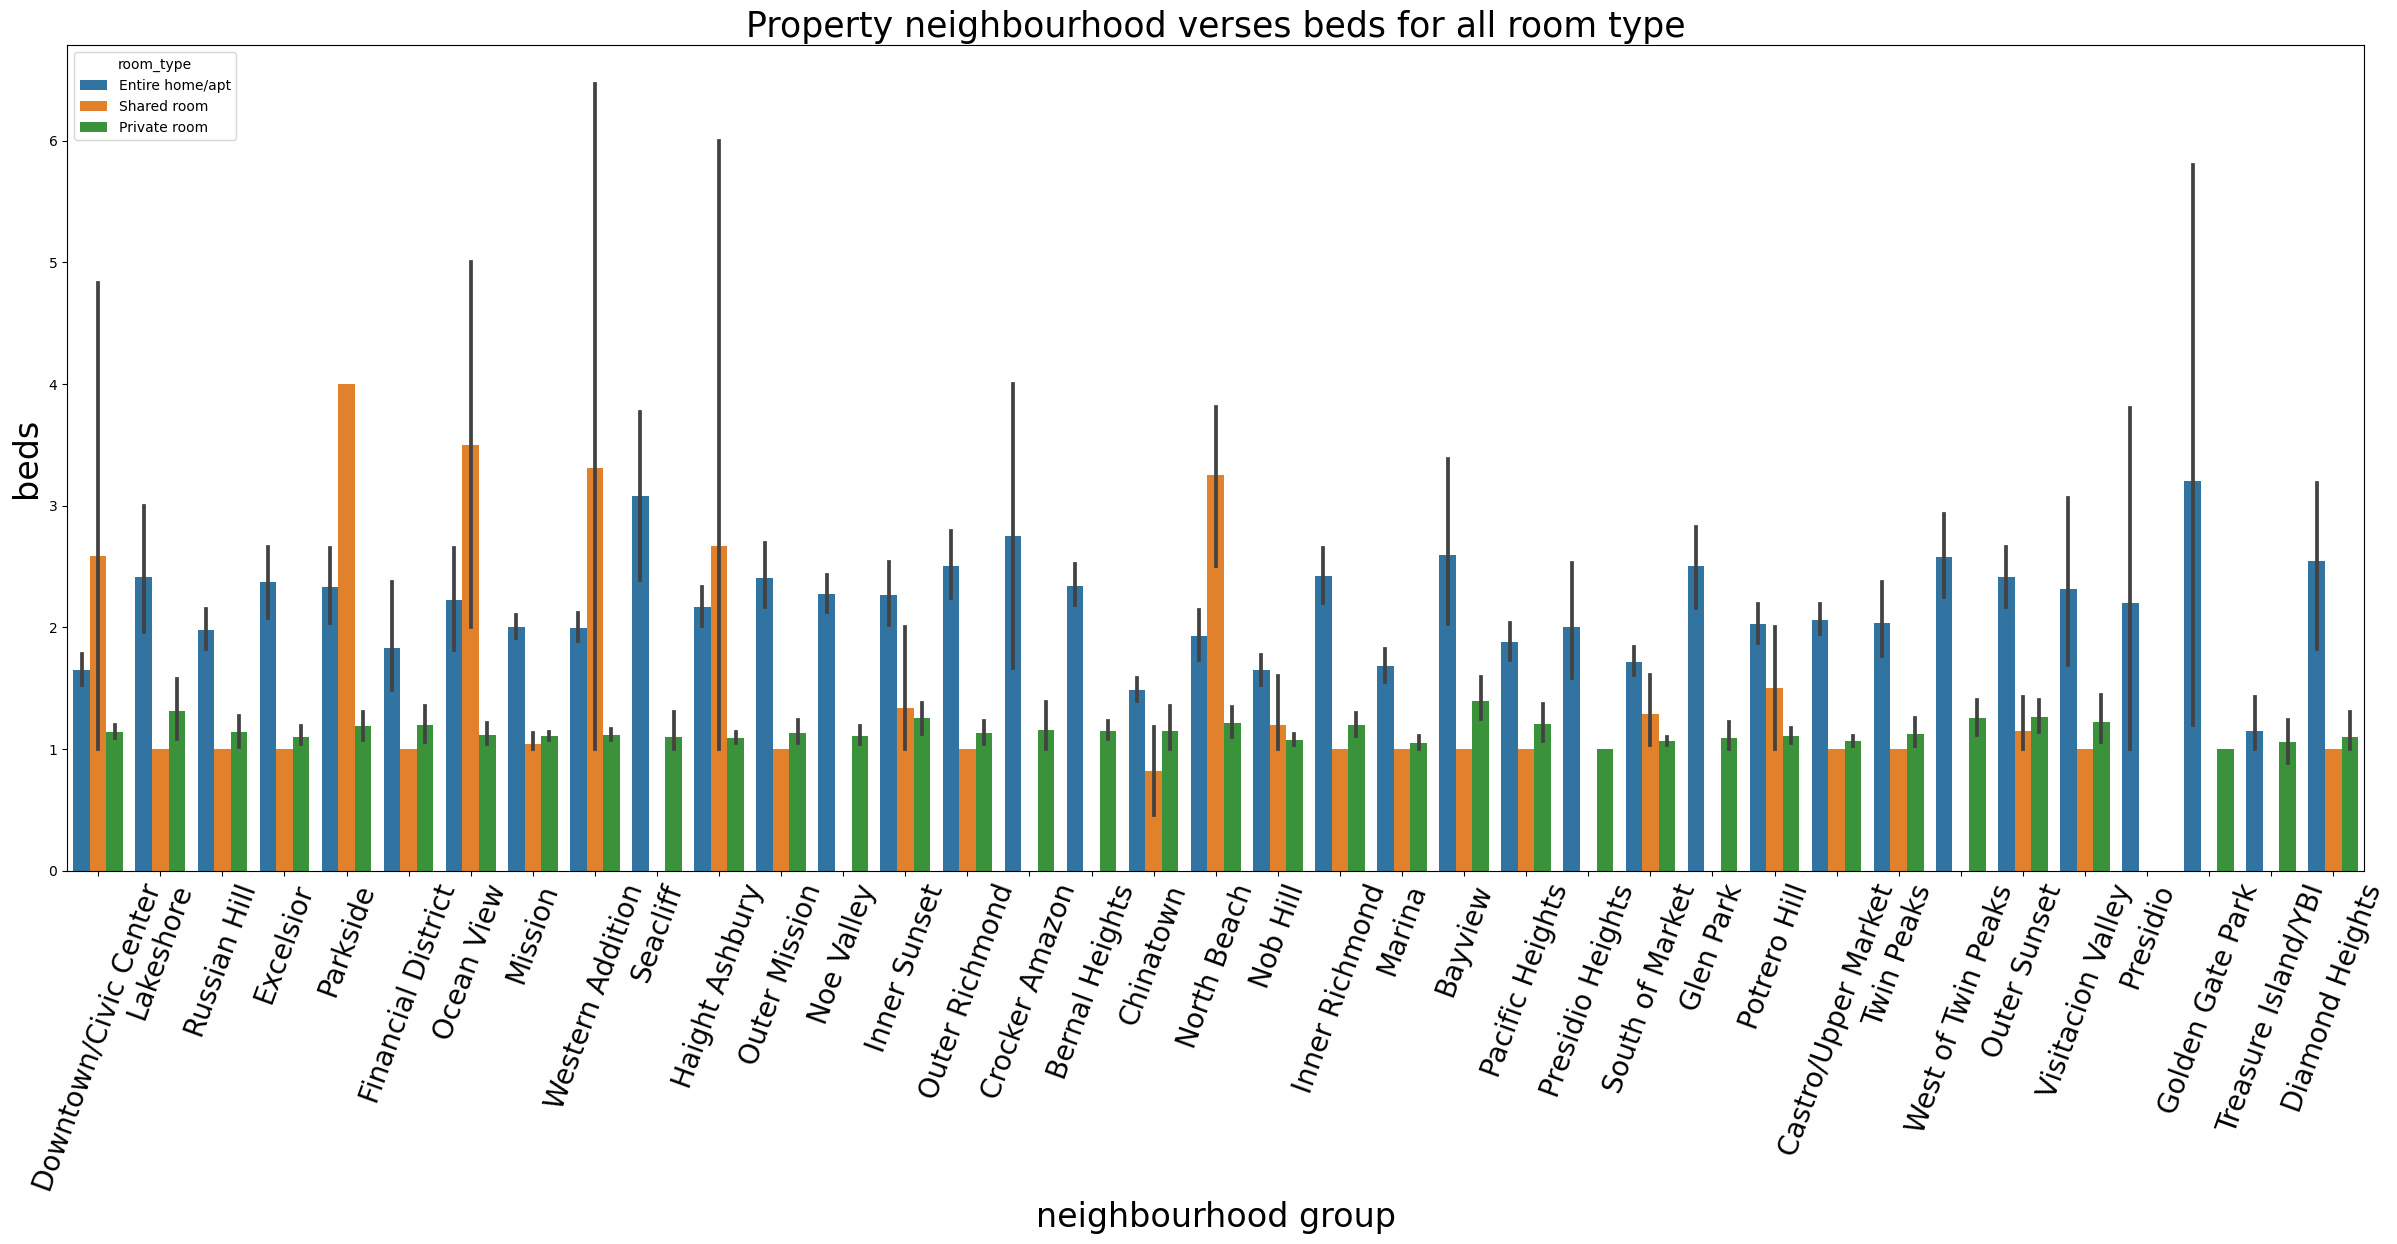

In [2795]:
# Visualize relationship between property neighbourhood verses beds for every room type
plt.figure(figsize=(24, 12))
sns.barplot(data=listings, x='neighbourhood_cleansed', y='beds', hue='room_type')
plt.xticks(rotation=70,fontsize=20)
plt.tight_layout()
plt.xlabel('neighbourhood group',fontsize=24)
plt.ylabel('beds',fontsize=24)
plt.title("Property neighbourhood verses beds for all room type", size=25, color="black")
plt.show()

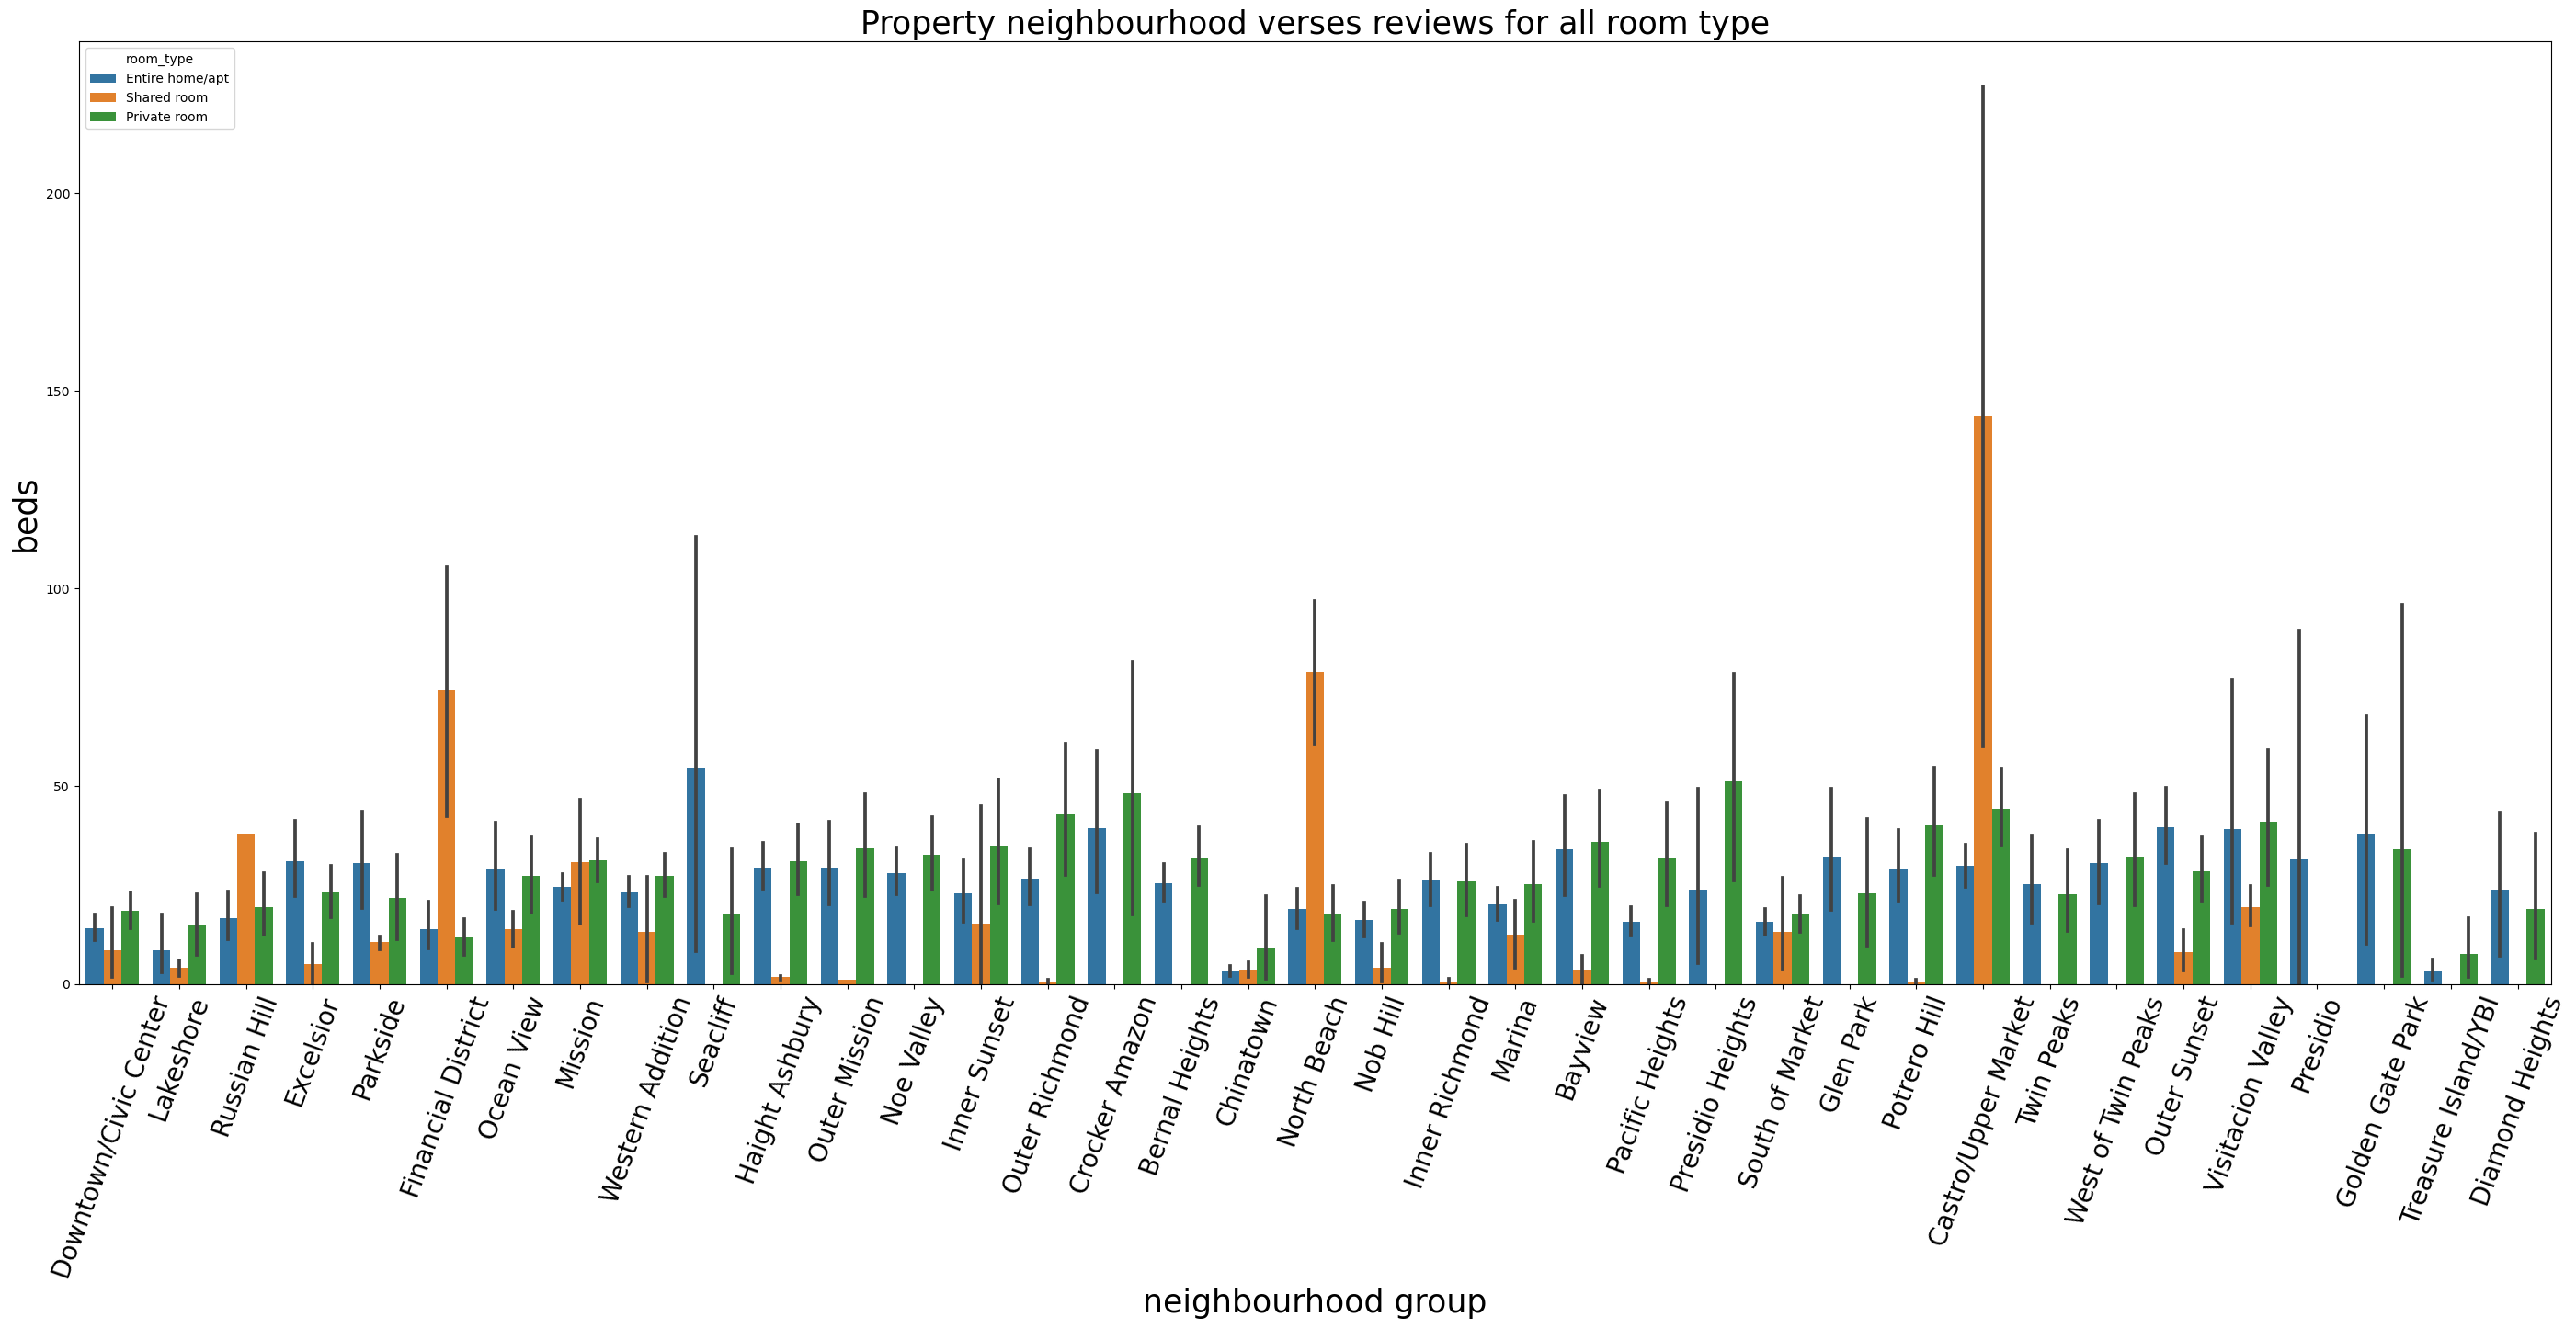

In [2796]:
# Visualize relationship between property neighbourhood verses reviews for every room type
plt.figure(figsize=(28, 14))
sns.barplot(data=listings, x='neighbourhood_cleansed', y='number_of_reviews', hue='room_type')
plt.xticks(rotation=70,fontsize=20)
plt.tight_layout()
plt.xlabel('neighbourhood group',fontsize=25)
plt.ylabel('beds',fontsize=25)
plt.title("Property neighbourhood verses reviews for all room type", size=25, color="black")
plt.show()

<AxesSubplot:xlabel='number_of_reviews', ylabel='reviews_per_month'>

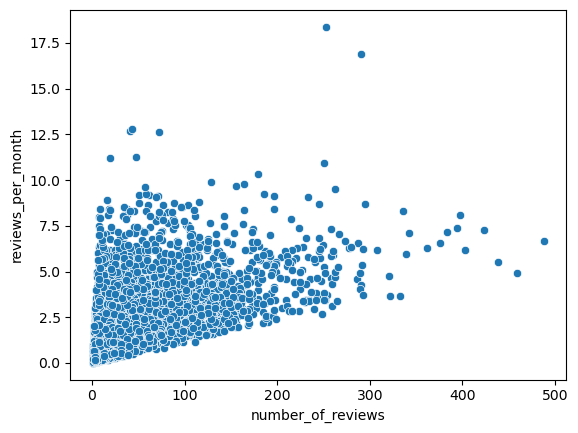

In [2797]:
# Number of reviews
sns.scatterplot(x=listings[listings['number_of_reviews']<600]['number_of_reviews'],
                y=listings[listings['reviews_per_month']<40]['reviews_per_month'])

In [2798]:
# Drop features which doesn't add value
listings.drop(columns=['listing_url','scrape_id', 'last_scraped','name','summary','space','description',
                       'experiences_offered','neighborhood_overview','country_code','country','notes',
                       'transit','access',
                       'interaction','house_rules','thumbnail_url','medium_url', 'picture_url', 
                       'xl_picture_url','host_id','host_url','host_name','host_since','host_location',
                       'host_about','host_response_time','host_response_rate','host_thumbnail_url',
                       'host_acceptance_rate','host_picture_url','host_neighbourhood','host_listings_count','host_verifications',
                       'neighbourhood','smart_location','latitude','longitude',
                       'square_feet','calendar_updated','calendar_last_scraped',
                       'first_review','last_review','license','jurisdiction_names','calculated_host_listings_count',
                       'reviews_per_month','geolocation'],inplace=True)

In [2799]:
# Create group of numerical features
##numerical_features = ['price','accommodates','bathrooms','bedrooms','beds','cleaning_fee',
##                      'guests_included','extra_people','minimum_nights',#'maximun_nights',
##                      'availability_30', 'availability_60', 'availability_90','availability_365', 
##                      'number_of_reviews','review_scores_rating', 'review_scores_accuracy', 
##                      'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
##                      'review_scores_location','review_scores_value']

numerical_features = ['price',
                      'accommodates',
                      'bathrooms',
                      'bedrooms',
                      'beds',
                      'cleaning_fee',
                      #'guests_included','extra_people',
                      'minimum_nights',#'maximun_nights',
                      'availability_30', 
                      #'availability_60', 
                      #'availability_90',
                      #'availability_365', 
                      'number_of_reviews',
                      #'review_scores_rating', 
                      #'review_scores_accuracy', 
                      #'review_scores_cleanliness',
                      #'review_scores_checkin',
                      #'review_scores_communication',
                      #'review_scores_location',
                      #'review_scores_value'
                    ]

In [2800]:
# Create group of categorical features
##categorical_features = ["neighbourhood_cleansed","city","state",#"zipcode",
##                        "property_type","room_type", "bed_type", "cancellation_policy",
##                        "instant_bookable","host_is_superhost","tv","cable_tv","internet",
##                        "wireless_internet","kitchen","breakfast","pets_allowed",
##                        "air_conditioning","heating","bathtub","pool","smoking_allowed",
##                        "hot_tub","washer","dryer","family/kid_friendly",
##                        "wheelchair_accessible", "indoor_fireplace","self_check-in","lockbox",
##                        "free_parking_on_premises","gym","smoke_detector",
##                        "carbon_monoxide_detector","first_aid_kit", "fire_extinguisher",
##                        "essentials","shampoo","24-hour_check-in", "review_score"
##                    ]

categorical_features = ["neighbourhood_cleansed",
                        "city",
                        "state",#"zipcode",
                        "property_type",
                        "room_type", 
                        "bed_type", 
                        "cancellation_policy",
                        "instant_bookable","host_is_superhost","tv","cable_tv","internet",
                        "wireless_internet","kitchen","breakfast","pets_allowed",
                        "air_conditioning","heating","bathtub","pool","smoking_allowed",
                        "hot_tub","washer","dryer","family/kid_friendly",
                        "wheelchair_accessible", "indoor_fireplace","self_check-in","lockbox",
                        "free_parking_on_premises","gym","smoke_detector",
                        "carbon_monoxide_detector","first_aid_kit", "fire_extinguisher",
                        "essentials","shampoo","24-hour_check-in", "review_score"
                    ]

In [2801]:
# Scale and transform
#   Scale the numerical features and encode the categorical features
preprocess_pipe  = ColumnTransformer([("numerical",  Pipeline([('scale', StandardScaler())]), numerical_features),
                                      ("categorical",Pipeline([('encode', OrdinalEncoder())]), categorical_features)])
df_features = listings[numerical_features + categorical_features].copy()
df_prepared = preprocess_pipe.fit_transform(listings[categorical_features + numerical_features])
df_features.reset_index(inplace=True)
del df_features["index"]

In [2802]:
# Test/Train split
#X = df_features.copy()
#del X["price"]
#y = df_features["price"].copy()
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [2803]:
#X_train.fillna(0, inplace=True)

In [2804]:
df_features.fillna(0, inplace=True)

In [2805]:
# Select numerical features
numerical_features = ['accommodates',
                      'bathrooms',
                      'bedrooms',
                      'beds',
                      'cleaning_fee',
                      'guests_included','extra_people',
                      'minimum_nights',#'maximun_nights',
                      'availability_30', 
                      'availability_60', 
                      'availability_90',
                      'availability_365', 
                      'number_of_reviews',
                      'review_scores_rating', 
                      'review_scores_accuracy', 
                      'review_scores_cleanliness',
                      'review_scores_checkin',
                      'review_scores_communication',
                      'review_scores_location',
                      'review_scores_value'
                    ]


In [2806]:
# Select categorical features
categorical_features = ["neighbourhood_cleansed",
                        "city",
                        "state",#"zipcode",
                        "property_type",
                        "room_type", 
                        "bed_type", 
                        "cancellation_policy",
                        "instant_bookable","host_is_superhost","tv","cable_tv","internet",
                        "wireless_internet","kitchen","breakfast","pets_allowed",
                        "air_conditioning","heating","bathtub","pool","smoking_allowed",
                        "hot_tub","washer","dryer","family/kid_friendly",
                        "wheelchair_accessible", "indoor_fireplace","self_check-in","lockbox",
                        "free_parking_on_premises","gym","smoke_detector",
                        "carbon_monoxide_detector","first_aid_kit", "fire_extinguisher",
                        "essentials","shampoo","24-hour_check-in", "review_score"]

## Linear Regression

In [2807]:
# Linear Regression model

# Perform numerical features transformation
numeric_transformer = Pipeline(steps=[('polynomial',PolynomialFeatures(degree=2)),
                                      ('scaler', StandardScaler())])

# Perform categorical features transformation
categorical_transformer = Pipeline([('ordinal_encoder', OrdinalEncoder())])

# Apply separate transformer for numerical and categorical features
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features),
                                                ('cat', categorical_transformer, categorical_features)],
                                 remainder='passthrough')
# Pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])
# Features for processing
df_feature_set = listings[['id'] + numerical_features + categorical_features + ['price']].copy()

# LabelEncode object feilds
le_cols=['neighbourhood_cleansed','city','state',
         'property_type','room_type','bed_type',
         'cancellation_policy','review_scores_value','review_score']
df_feature_set[le_cols] = df_feature_set[le_cols].apply(LabelEncoder().fit_transform).astype(int)

# Features
X = df_feature_set.drop('price', axis = 1)
X.fillna(0, inplace=True)

#Target
y = df_feature_set['price']

# Test/Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('polynomial',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['accommodates', 'bathrooms',
                                                   'bedrooms', 'beds',
                                                   'cleaning_fee',
                                                   'guests_included',
                                                   'extra_people',
                                                   'minimum_nights',
                                                   'availability_30',
                    

In [2808]:
# predict
y_pred = clf.predict(X_test)

# accuracy check
mse_clf = mean_squared_error(y_test, y_pred)
rmse_clf = np.sqrt(mse_clf)
mae_clf = mean_absolute_error(y_test, y_pred)
r2score_clf = r2_score(y_test, y_pred)

print("Train accuracy for linear regression model is : " + str(clf.score(X_train, y_train)))
print("Test accuracy for linear regression model is : " + str(clf.score(X_test, y_test)))
print("\nTest MSE: " + str(mse_clf))
print("Test MAE: " + str(mae_clf))
print("Test RMSE: " + str(rmse_clf))
print("Test R2 Score: " + str(r2score_clf))

# Cross-validation score
clf_cv = cross_val_score(clf, X_train, y_train,scoring="neg_mean_squared_error", cv=10)
clf_cv_rme = np.sqrt(-clf_cv)

print("Scores:", clf_cv_rme)
print("Mean:", clf_cv_rme.mean())
print("Standard deviation:", clf_cv_rme.std())

Train accuracy for linear regression model is : 0.6041292746932532
Test accuracy for linear regression model is : 0.5197375390601908

Test MSE: 11553.33170205698
Test MAE: 68.21008082398163
Test RMSE: 107.48642566415994
Test R2 Score: 0.5197375390601908
Scores: [ 99.54657278 109.51080943  95.88308659 110.96689554 102.49416003
  98.02785477 102.62696998 101.59026882 129.67111528 111.79585495]
Mean: 106.21135881839095
Standard deviation: 9.386855041845513


## DecisionTree Regression

In [2809]:
# Decision Tree model
dtree = DecisionTreeRegressor(random_state=42)

grid_params = {'max_depth':     [1, 20, 100], 
               'max_features':  [1, 5, 15, 20,40], 
               'max_leaf_nodes':[5, 50, 100]}

# Gridsearch
gs_dtree = GridSearchCV(estimator=dtree,
                        param_grid=grid_params,
                        scoring='neg_mean_squared_error',
                        cv=4,
                        return_train_score=True)

gs_dtree.fit(X_train, y_train)

#print(search.cv_results_)

# Score
best_est = gs_dtree.best_estimator_
score = best_est.score(X_train, y_train)
print("\nR-squared: ", score) 

# Best estimator
print("\nBest estimator: ")
print(gs_dtree.best_estimator_)

# Best parameters
print("\nBest parameters: ")
print(gs_dtree.best_params_)

print("\nCross Validation: ")
# score of each hyperparameter combination tested during the grid search
gs_cv_results = gs_dtree.cv_results_
for mean,cv_params in zip(gs_cv_results["mean_test_score"],gs_cv_results["params"]):
    print(np.sqrt(-mean), cv_params)


R-squared:  0.5636359622925379

Best estimator: 
DecisionTreeRegressor(max_depth=20, max_features=15, max_leaf_nodes=50,
                      random_state=42)

Best parameters: 
{'max_depth': 20, 'max_features': 15, 'max_leaf_nodes': 50}

Cross Validation: 
153.77017499686536 {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 5}
153.77017499686536 {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 50}
153.77017499686536 {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 100}
151.87863185330187 {'max_depth': 1, 'max_features': 5, 'max_leaf_nodes': 5}
151.87863185330187 {'max_depth': 1, 'max_features': 5, 'max_leaf_nodes': 50}
151.87863185330187 {'max_depth': 1, 'max_features': 5, 'max_leaf_nodes': 100}
136.09564302898232 {'max_depth': 1, 'max_features': 15, 'max_leaf_nodes': 5}
136.09564302898232 {'max_depth': 1, 'max_features': 15, 'max_leaf_nodes': 50}
136.09564302898232 {'max_depth': 1, 'max_features': 15, 'max_leaf_nodes': 100}
133.13520766625794 {'max_depth': 1, 'max_fea

Text(0.5, 1.0, 'Decision Tree - Important features')

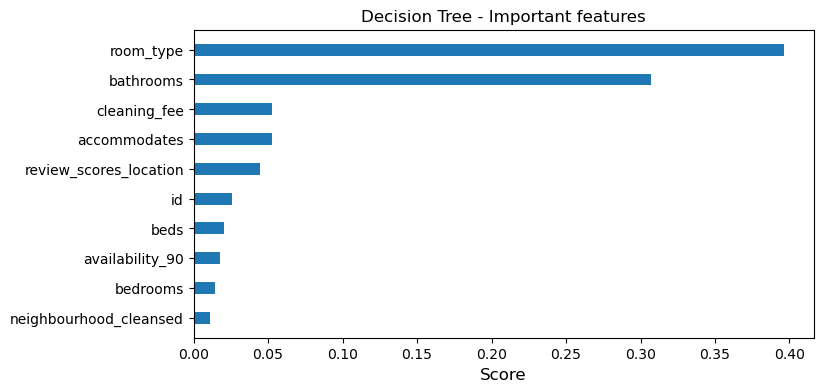

In [2810]:
### Feature importance
features = X_train.columns
score = best_est.feature_importances_
features_sorted = [x for y,x in sorted(zip(score, features))][::-1]
score_sorted = [y for y,x in sorted(zip(score, features))][::-1]

plt.figure(figsize=(8,4))
plt.barh(features_sorted[:10][::-1], score_sorted[:10][::-1], height=0.4)
plt.xlabel("Score", fontsize=12)
plt.title("Decision Tree - Important features", fontsize=12)

Text(0.5, 0, 'Time to fit(in seconds)')

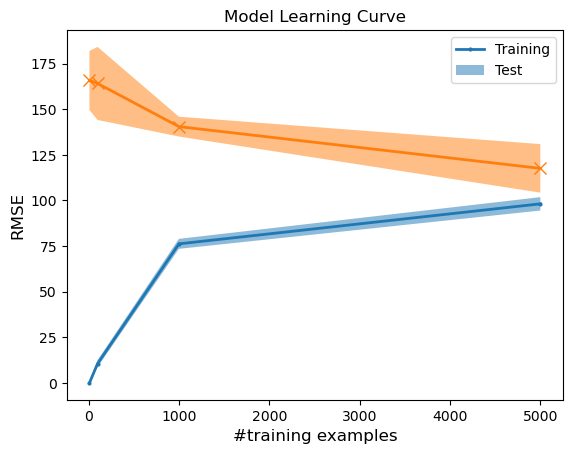

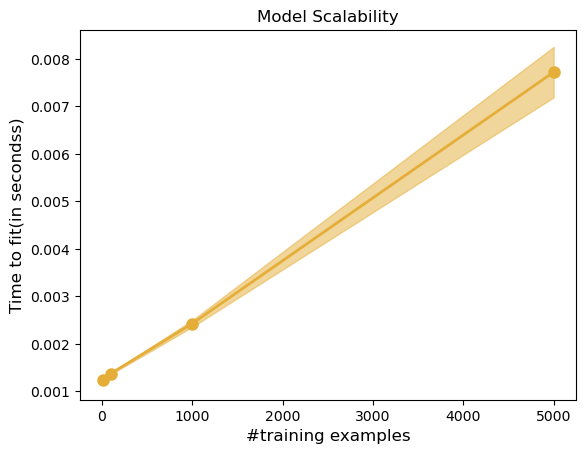

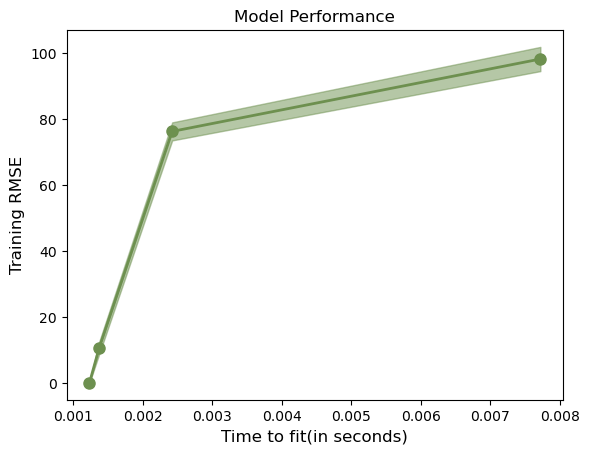

In [2811]:
# learning curve for different training set sizes
train_sizes,train_scores, 
valid_scores,fit_times, 
score_times = learning_curve(best_est,X,y,
                             train_sizes=[10, 100, 500, 1000, 2000, 5000],
                             cv=10,scoring="neg_mean_squared_error", 
                             return_times=True)
    
train_rmse      = np.sqrt(-train_scores)
train_rmse_mean = np.mean(train_rmse, axis=1)
train_rmse_std  = np.std(train_rmse, axis=1)

test_rmse       = np.sqrt(-valid_scores)
test_rmse_mean  = np.mean(test_rmse, axis=1)
test_rmse_std   = np.std(test_rmse, axis=1)

valid_rmse      = np.sqrt(-valid_scores)
valid_rmse_mean = np.mean(valid_rmse, axis=1)
valid_rmse_std  = np.std(valid_rmse, axis=1)

fit_times_mean  = np.mean(fit_times, axis=1)
fit_times_std   = np.std(fit_times, axis=1)

# Plot learning curve
plt.figure()
plt.plot(train_sizes, train_rmse_mean, 'o-', linewidth=2, markersize=2)
plt.fill_between(train_sizes, train_rmse_mean-2*train_rmse_std, train_rmse_mean+2*train_rmse_std, alpha=0.5)
plt.plot(train_sizes, test_rmse_mean, 'x-', linewidth=2, markersize=8)
plt.fill_between(train_sizes,test_rmse_mean-2*test_rmse_std,test_rmse_mean+2*test_rmse_std, alpha=0.5)
ax = plt.gca()
plt.title("Model Learning Curve", fontsize=12)
plt.xlabel("#training examples", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend(["Training", "Test"])

# Model scalability
plt.figure()
plt.plot(train_sizes, fit_times_mean, 'o-', linewidth=2, markersize=8, c="#e5ae38")
plt.fill_between(train_sizes, fit_times_mean-2*fit_times_std, fit_times_mean+2*fit_times_std, alpha=0.5, color="#e5ae38")
ax = plt.gca()
plt.title("Model Scalability", fontsize=12)
plt.xlabel("#training examples", fontsize=12)
plt.ylabel("Time to fit(in secondss)", fontsize=12)

### Model performance
plt.figure()
plt.plot(fit_times_mean, train_rmse_mean, 'o-', linewidth=2, markersize=8, c="#6d904f")
plt.fill_between(fit_times_mean, train_rmse_mean-2*train_rmse_std, train_rmse_mean+2*train_rmse_std, alpha=0.5, color="#6d904f")
plt.title("Model Performance", fontsize=12)
plt.ylabel("Training RMSE", fontsize=12)
plt.xlabel("Time to fit(in seconds)", fontsize=12)
    

## Random Forest Regression

In [2812]:
# RF regressor model
random_forest_regressor = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                                                max_depth=None, max_features='auto', max_leaf_nodes=None,
                                                max_samples=None, min_impurity_decrease=0.0,
                                                min_samples_split=2, min_weight_fraction_leaf=0.0,
                                                n_estimators=100, n_jobs=None, oob_score=False,
                                                random_state=None, verbose=0, warm_start=False)

# Train on the training data
random_forest_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest_regressor.predict(X_test)

# Evaluate the model
score = random_forest_regressor.score(X_test, y_test)
print("R-squared:", score) 

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 

R-squared: 0.5474637935210848
MSE:  10886.340961170214
RMSE:  5443.170480585107


In [2813]:
params = {'max_depth': [1, 20, 100], 
          'max_features': [1, 5, 15, 20,40], 
          'max_leaf_nodes': [5, 50, 100]
         }
gs_random_forest = GridSearchCV(estimator=random_forest_regressor, param_grid=params, cv=2,
                              scoring='neg_mean_squared_error', return_train_score=True)
gs_random_forest.fit(X_train, y_train)


print(gs_random_forest.cv_results_)
    
# Best estimator
print("Random Forest best parameters: ")
print(gs_random_forest.best_params_)
print("Random Forest best estimator: ")
print(gs_random_forest.best_estimator_)

print("Random Forest cross validation: ")

# hyperparameter
res = gs_random_forest.cv_results_
for mean_score, params in zip(res["mean_test_score"],res["params"]):
    print(np.sqrt(-mean_score), params)
    
random_forest_best_est = gs_random_forest.best_estimator_
score = random_forest_best_est.score(X_train, y_train)
print("Random Forest R-squared: ", score) 

{'mean_fit_time': array([0.0644486 , 0.06289411, 0.06309342, 0.07169735, 0.07087505,
       0.07173109, 0.09328318, 0.09253144, 0.09258676, 0.10188937,
       0.10284412, 0.10728693, 0.14412808, 0.14368331, 0.14245164,
       0.07012737, 0.08306289, 0.08913291, 0.09689713, 0.13800168,
       0.15699589, 0.16031194, 0.26228392, 0.30979407, 0.1933161 ,
       0.32646394, 0.39422786, 0.32423699, 0.58429599, 0.71958101,
       0.07042313, 0.08250701, 0.08892393, 0.09629643, 0.13782942,
       0.15516245, 0.16053951, 0.26390612, 0.31025434, 0.19004714,
       0.32345557, 0.38930547, 0.32003152, 0.58124661, 0.71289802]), 'std_fit_time': array([1.84655190e-03, 5.28097153e-04, 3.19480896e-04, 4.25577164e-05,
       1.05023384e-04, 1.71184540e-04, 1.03306770e-03, 5.41448593e-04,
       2.37941742e-04, 1.59263611e-04, 1.08706951e-03, 1.09291077e-03,
       2.27785110e-03, 4.48584557e-04, 1.90615654e-04, 4.97460365e-04,
       2.10046768e-04, 2.22086906e-04, 2.50339508e-05, 9.04560089e-04,
      

Text(0.5, 1.0, 'Feature Importance (Random Forest)')

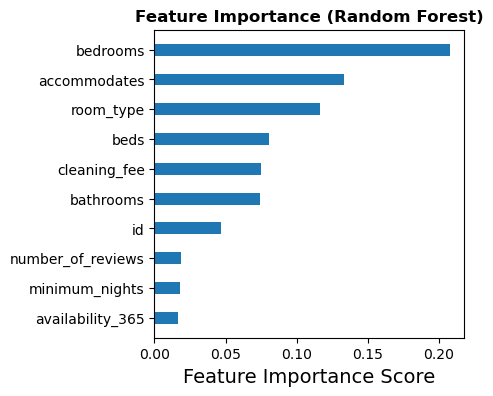

In [2814]:
### Feature importance
features = X_train.columns
score = random_forest_best_est.feature_importances_

features_sorted = [x for y,x in sorted(zip(score, features))][::-1]
score_sorted = [y for y,x in sorted(zip(score, features))][::-1]

plt.figure(figsize=(4,4))
plt.barh(features_sorted[:10][::-1], score_sorted[:10][::-1], height=0.4)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Feature Importance (Random Forest)", fontsize=12, fontweight="bold")

Text(0.5, 0, 'Time to fit(in seconds)')

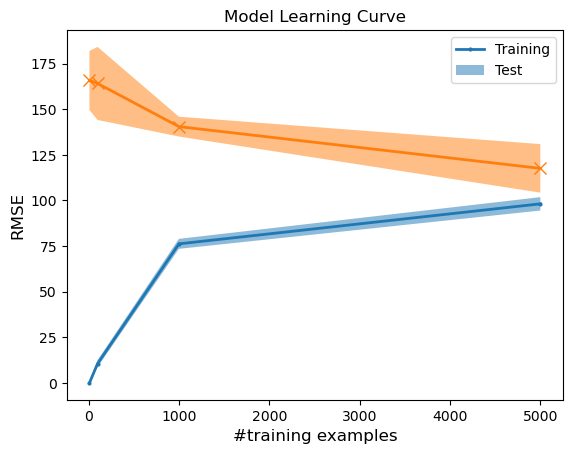

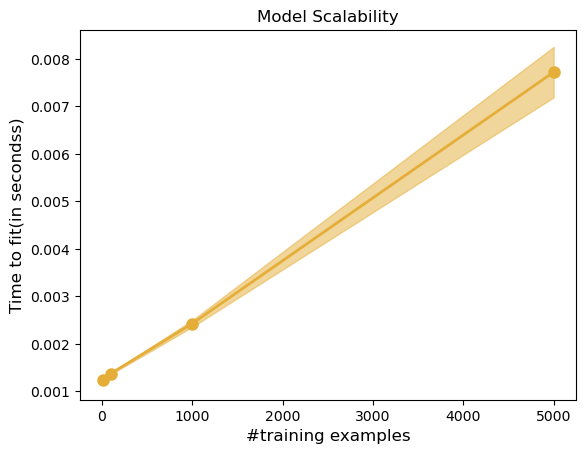

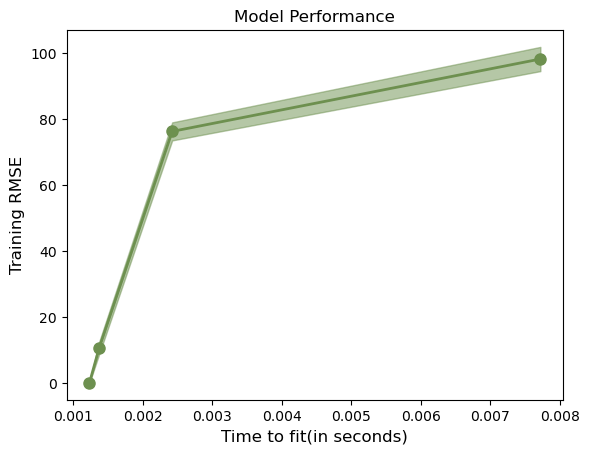

In [2815]:
# learning curve for different training set sizes
train_sizes,train_scores, 
valid_scores,fit_times, 
score_times = learning_curve(random_forest_best_est,X,y,
                             train_sizes=[10, 100, 500, 1000, 2000, 5000],
                             cv=10,scoring="neg_mean_squared_error", 
                             return_times=True)
    
train_rmse      = np.sqrt(-train_scores)
train_rmse_mean = np.mean(train_rmse, axis=1)
train_rmse_std  = np.std(train_rmse, axis=1)

test_rmse       = np.sqrt(-valid_scores)
test_rmse_mean  = np.mean(test_rmse, axis=1)
test_rmse_std   = np.std(test_rmse, axis=1)

valid_rmse      = np.sqrt(-valid_scores)
valid_rmse_mean = np.mean(valid_rmse, axis=1)
valid_rmse_std  = np.std(valid_rmse, axis=1)

fit_times_mean  = np.mean(fit_times, axis=1)
fit_times_std   = np.std(fit_times, axis=1)

# Plot learning curve
plt.figure()
plt.plot(train_sizes, train_rmse_mean, 'o-', linewidth=2, markersize=2)
plt.fill_between(train_sizes, train_rmse_mean-2*train_rmse_std, train_rmse_mean+2*train_rmse_std, alpha=0.5)
plt.plot(train_sizes, test_rmse_mean, 'x-', linewidth=2, markersize=8)
plt.fill_between(train_sizes,test_rmse_mean-2*test_rmse_std,test_rmse_mean+2*test_rmse_std, alpha=0.5)
ax = plt.gca()
plt.title("Model Learning Curve", fontsize=12)
plt.xlabel("#training examples", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend(["Training", "Test"])

# Model scalability
plt.figure()
plt.plot(train_sizes, fit_times_mean, 'o-', linewidth=2, markersize=8, c="#e5ae38")
plt.fill_between(train_sizes, fit_times_mean-2*fit_times_std, fit_times_mean+2*fit_times_std, alpha=0.5, color="#e5ae38")
ax = plt.gca()
plt.title("Model Scalability", fontsize=12)
plt.xlabel("#training examples", fontsize=12)
plt.ylabel("Time to fit(in secondss)", fontsize=12)

### Model performance
plt.figure()
plt.plot(fit_times_mean, train_rmse_mean, 'o-', linewidth=2, markersize=8, c="#6d904f")
plt.fill_between(fit_times_mean, train_rmse_mean-2*train_rmse_std, train_rmse_mean+2*train_rmse_std, alpha=0.5, color="#6d904f")
plt.title("Model Performance", fontsize=12)
plt.ylabel("Training RMSE", fontsize=12)
plt.xlabel("Time to fit(in seconds)", fontsize=12)
    

### Gradient Boost Regression

In [2816]:
# Gradient Boost model
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'}

model_xgb = ensemble.GradientBoostingRegressor(**params)
model_xgb.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=500)

In [2817]:
# Display feature importance
print(model_xgb.feature_importances_)

[4.43160472e-02 1.46344062e-01 8.24970029e-02 3.64672636e-01
 1.25445095e-02 6.46129723e-02 3.12725649e-03 1.46596331e-02
 2.39060387e-02 1.12047811e-03 4.98176046e-03 2.20320805e-02
 1.23986129e-02 4.23390082e-02 1.76728897e-02 5.97501760e-03
 1.84698743e-03 5.31956784e-03 2.49633229e-03 6.96821232e-03
 4.16779552e-03 9.42806756e-03 0.00000000e+00 0.00000000e+00
 9.59368487e-04 7.40219839e-02 8.49038366e-05 2.60914397e-03
 0.00000000e+00 4.08996588e-04 1.99772117e-04 9.12412421e-03
 5.95188234e-04 1.40824776e-03 2.58303689e-04 0.00000000e+00
 6.73469714e-04 3.25062257e-03 6.87516300e-04 3.66428505e-04
 1.88869858e-03 8.24620205e-05 3.55266634e-04 1.16826856e-03
 6.13279209e-05 2.82773719e-04 1.11161917e-03 4.22184539e-03
 3.68145852e-06 0.00000000e+00 6.25778279e-05 1.07324965e-03
 4.93649089e-05 1.34122177e-05 5.73919230e-04 6.70103335e-05
 3.72725173e-04 5.27682150e-04 3.82424957e-06 5.25266398e-06]


Text(0.5, 1.0, 'Feature Importance (XGBoost)')

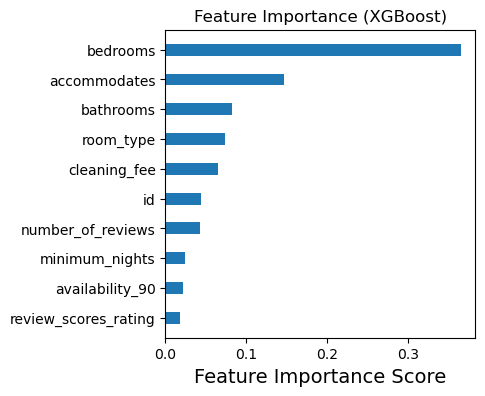

In [2818]:
# plot feature importance
features = X_train.columns
score = model_xgb.feature_importances_

features_sorted = [x for y,x in sorted(zip(score, features))][::-1]
score_sorted = [y for y,x in sorted(zip(score, features))][::-1]

plt.figure(figsize=(4,4))
plt.barh(features_sorted[:10][::-1], score_sorted[:10][::-1], height=0.4)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Feature Importance (XGBoost)", fontsize=12)


## Model Evaluation

In [2819]:
def get_test_results(features, target, model):
    test_results = {}
    
    y_pred = model.predict(features)
    mse = mean_squared_error(target, y_pred)
    rmse = np.sqrt(mse)
    squared_errors = (y_pred - y_test) ** 2
    mean = squared_errors.mean()
    test_results["labels"] = y_test
    test_results["predictions"] = y_pred
    test_results["squared_errors"] = squared_errors
    test_results["mse"] = mse
    test_results["rmse"] = rmse
    test_results["errors"] = np.sqrt(squared_errors)
    return test_results

In [2820]:
# validate all models
df_feature_set.fillna(0, inplace=True)
# Features
X = df_feature_set.drop('price', axis = 1)
#Target
y = df_feature_set['price']
# Test/Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linreg = get_test_results(X_test,y_test, clf)
dectree = get_test_results(X_test,y_test, best_est)
rf = get_test_results(X_test,y_test,random_forest_best_est)
xgb = get_test_results(X_test,y_test,model_xgb)

Text(0.5, 1.0, 'Model Comparison on Test Data ')

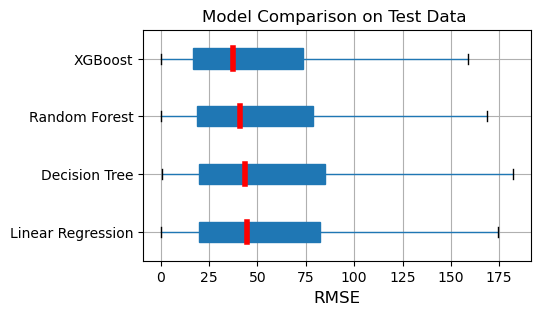

In [2821]:
# Plot model comparison
dft = pd.DataFrame()
dft["Linear Regression"] = linreg["errors"]
dft["Decision Tree"] = dectree["errors"]
dft["Random Forest"] = rf["errors"]
dft["XGBoost"] = xgb["errors"]

plt.figure(figsize=(5,3))
dft.boxplot(showfliers=False, patch_artist=True, medianprops=dict(linestyle='-', linewidth=4, color='red'),
            vert=False, widths=0.35)
ax = plt.gca()
ax.set_xlabel("RMSE", fontsize=12)
ax.set_title("Model Comparison on Test Data ", fontsize=12 )

In [2822]:
# Benchmark
ModelsBenchmark = pd.DataFrame()
ModelsBenchmark['model'] = []
ModelsBenchmark['best_score'] = []
ModelsBenchmark['timing_secs'] = []

def model_append_metrics(model,modelname,best_score, timing_secs):
    best_score=best_score
    list_row = [modelname, best_score,timing_secs]
    ModelsBenchmark.loc[len(ModelsBenchmark)] = list_row

def run_model(model, model_name,X,y): 
    start = time.time()
    y_pred = model.predict(X)
    end = time.time()
    model_append_metrics(model, model_name, str(model.score(X, y)), str(end - start))

In [2823]:
# Save benchmark
run_model(clf, "Linear Regression",X_test,y_test)
run_model(best_est, "Decision Tree Regression",X_test,y_test)
run_model(random_forest_best_est, "Random Forest Regression",X_test,y_test)
run_model(model_xgb, "XGBoost Regression",X_test,y_test)

In [2824]:
pd.DataFrame(ModelsBenchmark)

model          best_score            timing_secs
0         Linear Regression  0.5197375390601908   0.012083053588867188
1  Decision Tree Regression  0.4421209277742283  0.0009381771087646484
2  Random Forest Regression  0.5374273902130164   0.012018918991088867
3        XGBoost Regression  0.5732624853445343   0.016012907028198242

## Save model

In [2450]:
with open('model.pickle', 'wb') as f:
    pickle.dump(model_xgb, f)